# Scientific Workflow with HSSM

<center> <img src="images/HSSM_logo.png"> </center>

## Colab Instructions

If you would like to run this tutorial on Google colab, please click this [link](https://github.com/lnccbrown/HSSM/blob/main/docs/tutorials/main_tutorial.ipynb). 

Once you are *in the colab*, follow the *installation instructions below* and then **restart your runtime**. 

Just **uncomment the code in the next code cell** and run it!

**NOTE**:

You may want to *switch your runtime* to have a GPU or TPU. To do so, go to *Runtime* > *Change runtime type* and select the desired hardware accelerator.

Note that if you switch your runtime you have to follow the installation instructions again.

In [101]:
# If running this on Colab, please uncomment the next line
# !pip install hssm

In [ ]:
# !wget -P  data/carney_workshop_2025_data/ https://raw.githubusercontent.com/lnccbrown/HSSM/drop-more-notebooks-from-execute/carney_workshop/data/carney_workshop_2025_data/carney_workshop_2025_full.parquet
# !wget -P  data/carney_workshop_2025_data/ https://raw.githubusercontent.com/lnccbrown/HSSM/drop-more-notebooks-from-execute/carney_workshop/data/carney_workshop_2025_data/carney_workshop_2025_modeling.parquet
# !wget -P  data/carney_workshop_2025_data/ https://raw.githubusercontent.com/lnccbrown/HSSM/drop-more-notebooks-from-execute/carney_workshop/data/carney_workshop_2025_data/carney_workshop_2025_parameters.pkl


# !wget -P  idata/basic_ddm/ https://raw.githubusercontent.com/lnccbrown/HSSM/drop-more-notebooks-from-execute/carney_workshop/idata/basic_ddm/traces.nc
# !wget -P  idata/ddm_hier/ https://raw.githubusercontent.com/lnccbrown/HSSM/drop-more-notebooks-from-execute/carney_workshop/idata/ddm_hier/traces.nc
# !wget -P  idata/angle_hier/ https://raw.githubusercontent.com/lnccbrown/HSSM/drop-more-notebooks-from-execute/carney_workshop/idata/angle_hier/traces.nc
# !wget -P  idata/angle_hier_v2/ https://raw.githubusercontent.com/lnccbrown/HSSM/drop-more-notebooks-from-execute/carney_workshop/idata/angle_hier_v2/traces.nc
# !wget -P  idata/angle_hier_v3/ https://raw.githubusercontent.com/lnccbrown/HSSM/drop-more-notebooks-from-execute/carney_workshop/idata/angle_hier_v3/traces.nc
# !wget -P  idata/angle_hier_v4/ https://raw.githubusercontent.com/lnccbrown/HSSM/drop-more-notebooks-from-execute/carney_workshop/idata/angle_hier_v4/traces.nc
# !wget -P  idata/angle_v5/ https://raw.githubusercontent.com/lnccbrown/HSSM/drop-more-notebooks-from-execute/carney_workshop/idata/angle_v5/traces.nc

#### Load modules

In [102]:
import hssm
import pandas as pd
import pickle
import numpy as np
import arviz as az
from matplotlib import pyplot as plt

#### Load workshop data

In [103]:
def load_data(filename_base: str,
              folder: str = "data") -> tuple[pd.DataFrame, pd.DataFrame, dict]:
    """Load saved simulation data and parameters from files.

    Parameters
    ----------
    filename_base : str
        Base filename used when saving files
    folder : str, optional
        Folder containing saved files, by default "data"

    Returns
    -------
    tuple[pd.DataFrame, pd.DataFrame, dict]
        Contains:
        - DataFrame with modeling data
        - DataFrame with full data  
        - Dict containing group and subject parameters
    """
    with open(f"{folder}/{filename_base}_parameters.pkl", "rb") as f:
        parameters = pickle.load(f)
    
    df_modeling = pd.read_parquet(f"{folder}/{filename_base}_modeling.parquet")
    df_ordered = pd.read_parquet(f"{folder}/{filename_base}_full.parquet")
    return df_ordered, df_modeling, parameters

In [104]:
_, workshop_data, _ = load_data(filename_base = "carney_workshop_2025",
                                folder = "data/carney_workshop_2025_data")

#### Load Plotting Utilities

In [150]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Colors

BAR_COLORS = {-1: 'gray', 1: 'black'}

def plot_rt_by_choice(df: pd.DataFrame,
                      categorical_column: str | None = None,
                      colors: dict[str, str] | dict[int, str] | None = None,
                      ax: plt.Axes | None = None):
    if categorical_column is None:
        ax.hist(df['rt'] * df['response'],
                bins = np.linspace(-5,5, 50), 
                # label=f'Condition {cond}', 
                histtype='step',
                density = True,
                color='tab:blue')
    else:
        for cond in df[categorical_column].unique():
            df_cond = df[df[categorical_column] == cond]
            ax.hist(df_cond['rt'] * df_cond['response'],
                    bins = np.linspace(-5,5, 50), 
                    label=f'Condition {cond}', 
                    histtype='step',
                    density = True,
                    color=colors[cond])
        ax.set_xlabel('RT * Choice')
        ax.set_ylabel('Density')
    return ax
        
def inset_bar_plot(df: pd.DataFrame, 
                   categorical_column: str,
                   response_options: list[int],
                   colors: dict[str, str] | dict[int, str] | None = None,
                   ax: plt.Axes | None = None):
    
    axins = inset_axes(ax, 
                       width="35%",
                       height="35%",
                       loc='upper left',
                       borderpad=2.75)
    bar_width = 0.55
    for j, resp in enumerate(response_options):
        for k, cond in enumerate(df[categorical_column].unique()):
            k_displace = -1 if k == 0 else 1
            df_cond = df[df[categorical_column] == cond]
            prop = (df_cond[df_cond.response == resp].shape[0] / len(df_cond))
            axins.bar((resp + ((bar_width / 2) * k_displace)), 
                        prop,
                        width=bar_width,
                        fill = False,
                        edgecolor=colors[cond],
                        label=f'Response {resp}')
    axins.set_xticks(response_options)
    axins.set_ylim(0, 1)
    axins.set_yticks([0.0, 0.5, 1])
    axins.set_title('choice proportion / option', fontsize=8)
    axins.tick_params(axis='both', which='major', labelsize=7)
    axins.set_xlabel('')
    axins.set_ylabel('')
    return ax

def inset_bar_plot_vertical(df: pd.DataFrame,
                            categorical_column: str,
                            response_options: list[int],
                            colors: dict[str, str] | dict[int, str] | None = None,
                            ax: plt.Axes | None = None):
    
    axins = inset_axes(ax,
                       width="35%",
                       height="35%",
                       loc='upper left',
                       borderpad=2.25)
    bar_width = 0.55
    for j, resp in enumerate(response_options):
        # k_displace_dict = {0:}
        for k, cond in enumerate(df[categorical_column].unique()):
            k_displace = -1 if k == 0 else 1
            df_cond = df[df[categorical_column] == cond]
            rt_mean = (df_cond[df_cond.response == resp]).rt.mean()
            axins.barh((resp + ((bar_width / 2) * k_displace)), 
                       rt_mean,
                       height=bar_width,
                       fill = False,
                       edgecolor=colors[cond],
                       label=f'Response {resp}')

    axins.set_yticks(response_options)
    axins.set_xticks([0.0, 1., 2.])
    axins.set_title('rt-mean by choice option', fontsize=8)
    axins.tick_params(axis='both', which='major', labelsize=7)
    axins.set_xlabel('')
    axins.set_ylabel('')
    return ax

def plot_rt_hists(df: pd.DataFrame,
                  by_participant: bool = True,
                  split_by_column: str | None = None,
                  inset_plot: str | None = "choice proportion",
                  cols: int = 5):
    if split_by_column is not None:
        colors = {cond: color for cond, color in zip(df[split_by_column].unique(), 
                            ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple'])}
    else:
        colors = None

    if by_participant:
        # Get unique participant IDs and costly_fail_conditions
        participants = df['participant_id'].unique()

        # Set up subplot grid (adjust cols as needed)
        rows = (len(participants) + cols - 1) // cols
        fig, axes = plt.subplots(rows, cols, 
                                 figsize=(cols*4, rows*3), 
                                 sharey=True, sharex=True)
        axes = axes.flatten()
        for i, pid in enumerate(participants):
            ax = axes[i]
            df_part = df[df['participant_id'] == pid]
            ax = plot_rt_by_choice(df_part,
                                   split_by_column,
                                   colors,
                                   ax)
            
            # Take care of inset plots
            if inset_plot == "choice_proportion":
                ax = inset_bar_plot(df_part, 
                                    split_by_column,
                                    df['response'].unique(),
                                    colors,
                                    ax)
            elif inset_plot == "rt_mean":
                ax = inset_bar_plot_vertical(df_part, 
                                             split_by_column,
                                             df['response'].unique(),
                                             colors,
                                             ax)
            if i == 0:
                ax.legend(title=split_by_column, loc='best', fontsize='small')

        # Hide unused axes
        for j in range(i+1, len(axes)):
            axes[j].set_visible(False)

        plt.tight_layout()
        plt.suptitle('RT, Split by Costly Fail Condition and Participant', y=1.02)
        plt.show()
    else:
        fig, ax = plt.subplots(1, 1, figsize=(4, 3))
        ax = plot_rt_by_choice(df,
                               split_by_column,
                               colors,
                               ax)

        # Take care of inset plots
        if inset_plot == "choice_proportion":
            ax = inset_bar_plot(df,
                                split_by_column,
                                df['response'].unique(),
                                colors,
                                ax)
        elif inset_plot == "rt_mean":
            ax = inset_bar_plot_vertical(df,
                                         split_by_column,
                                         df['response'].unique(),
                                         colors,
                                         ax)
        
        ax.legend(title=split_by_column, loc='best', fontsize='small')
        plt.tight_layout()
        plt.suptitle('RT by Trial, Split by Costly Fail Condition', y=1.02)
        plt.show()

## Exploratory Data Analysis

<center> <img src="images/Experiment.png" height=300 width=700> </center>


In [151]:
# Binary version of difficulty
workshop_data['bin_difficulty'] = workshop_data['continuous_difficulty'].apply(lambda x: 'high' if x > 0 else 'low')

# I want a a ordinal variable that is composed of 5 quantile levels of difficulty
workshop_data['quantile_difficulty'] = pd.qcut(workshop_data['continuous_difficulty'],
                                                             3, labels = ['-1', '0', '1'])

workshop_data['quantile_difficulty_binary'] = pd.qcut(workshop_data['continuous_difficulty'],
                                                             2, labels = ['-1', '1'])

# Slightly
workshop_data['response_l1_plotting'] = workshop_data['response_l1'].apply(lambda x: str(-1) if x == -1 else str(1))


In [152]:
workshop_data

response        rt participant_id  trial  costly_fail_condition  \
0            1  0.556439              0      1                      1   
1            1  0.741682              0      2                      0   
2            1  0.461832              0      3                      0   
3            1  0.626154              0      4                      0   
4            1  0.651677              0      5                      1   
...        ...       ...            ...    ...                    ...   
4995         1  1.039342             19    246                      0   
4996         1  1.587827             19    247                      0   
4997         1  0.668594             19    248                      1   
4998         1  1.616471             19    249                      0   
4999         1  1.051329             19    250                      1   

      continuous_difficulty  response_l1 bin_difficulty quantile_difficulty  \
0                 -0.277337            0            low                   0   
1                 -0.810919            1            low                  -1   
2                 -0.673330            1            low                  -1   
3                  0.755445            1           high                   1   
4                  0.136755            1           high                   0   
...                     ...          ...            ...                 ...   
4995              -0.612223           -1            low                  -1   
4996               0.732396            1           high                   1   
4997              -0.175321            1            low                   0   
4998              -0.630447            1            low                  -1   
4999               0.511197            1           high                   1   

     response_l1_plotting quantile_difficulty_binary  
0                       1                         -1  
1                       1                         -1  
2                       1                         -1  
3                       1                          1  
4                       1                          1  
...                   ...                        ...  
4995                   -1                         -1  
4996                    1                          1  
4997                    1                         -1  
4998                    1                         -1  
4999                    1                          1  

[5000 rows x 11 columns]

/var/folders/gx/s43vynx550qbypcxm83fv56dzq4hgg/T/ipykernel_35355/4118783030.py:170: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title=split_by_column, loc='best', fontsize='small')


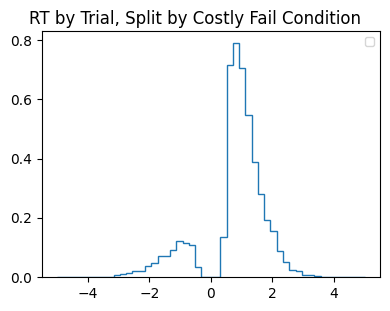

In [153]:
plot_rt_hists(workshop_data, 
              by_participant = False, 
              split_by_column = None,
              inset_plot = None)

### Basic Model: DDM

<center> <img src="images/DDM_with_params_pic.png" height="500" width="500"> </center>

In [10]:
BasicDDMModel = hssm.HSSM(data = workshop_data,
                          model = "ddm",
                          loglik_kind = "approx_differentiable",
                          global_formula = "y ~ 1",
                          noncentered = False,
                          )

Model initialized successfully.


In [11]:
BasicDDMModel

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: approx_differentiable
Observations: 5000

Parameters:

v:
    Formula: v ~ 1
    Priors:
        v_Intercept ~ Normal(mu: 0.0, sigma: 0.25)
    Link: identity
    Explicit bounds: (-3.0, 3.0)

a:
    Formula: a ~ 1
    Priors:
        a_Intercept ~ Normal(mu: 1.4, sigma: 0.25)
    Link: identity
    Explicit bounds: (0.3, 2.5)

z:
    Formula: z ~ 1
    Priors:
        z_Intercept ~ Normal(mu: 0.5, sigma: 0.25)
    Link: identity
    Explicit bounds: (0.0, 1.0)

t:
    Formula: t ~ 1
    Priors:
        t_Intercept ~ Normal(mu: 1.0, sigma: 0.25)
    Link: identity
    Explicit bounds: (0.0, 2.0)


Lapse probability: 0.05
Lapse distribution: Uniform(lower: 0.0, upper: 20.0)

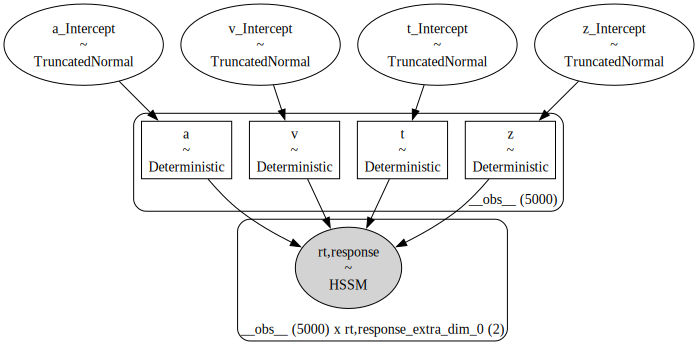

In [12]:
BasicDDMModel.graph()

In [13]:
try:
    # Load pre-computed traces
    BasicDDMModel.restore_traces(traces = "idata/basic_ddm/traces.nc")
except:
    # Sample posterior
    basic_ddm_idata = BasicDDMModel.sample(chains = 2,
                                            sampler = "nuts_numpyro",
                                            tune = 500,
                                            draws = 500,
                                        )

    # Sample posterior predictive
    BasicDDMModel.sample_posterior_predictive(draws = 200,
                                              safe_mode = True)

    # Save Model
    BasicDDMModel.save_model(model_name = "basic_ddm",
                             allow_absolute_base_path = True,
                             base_path = "idata/",
                             save_idata_only = True)

In [14]:
BasicDDMModel.traces

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

In [15]:
az.summary(BasicDDMModel.traces)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
t_Intercept  0.328  0.005   0.317    0.338      0.000    0.000     576.0   
z_Intercept  0.466  0.007   0.453    0.478      0.000    0.000     529.0   
a_Intercept  1.017  0.009   1.000    1.033      0.000    0.000     583.0   
v_Intercept  0.943  0.023   0.900    0.985      0.001    0.001     536.0   

             ess_tail  r_hat  
t_Intercept     573.0    1.0  
z_Intercept     496.0    1.0  
a_Intercept     610.0    1.0  
v_Intercept     526.0    1.0

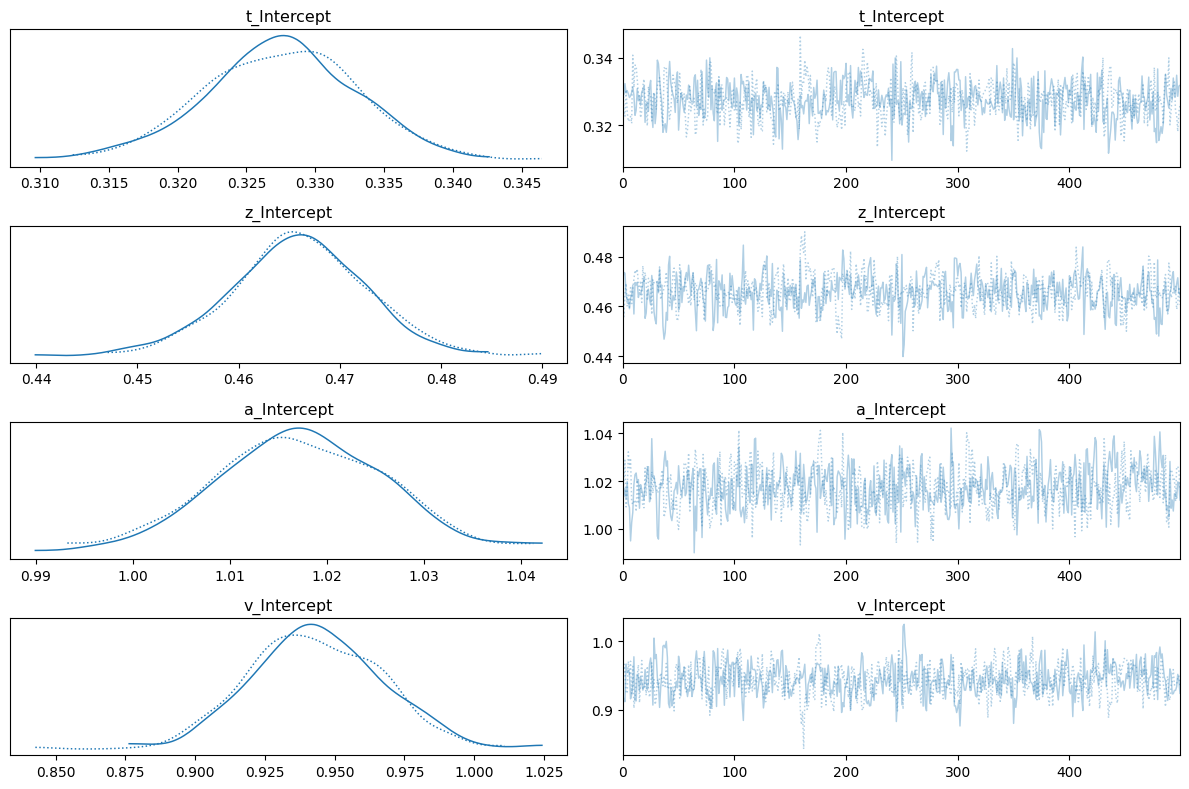

In [16]:
az.plot_trace(BasicDDMModel.traces)
plt.tight_layout()

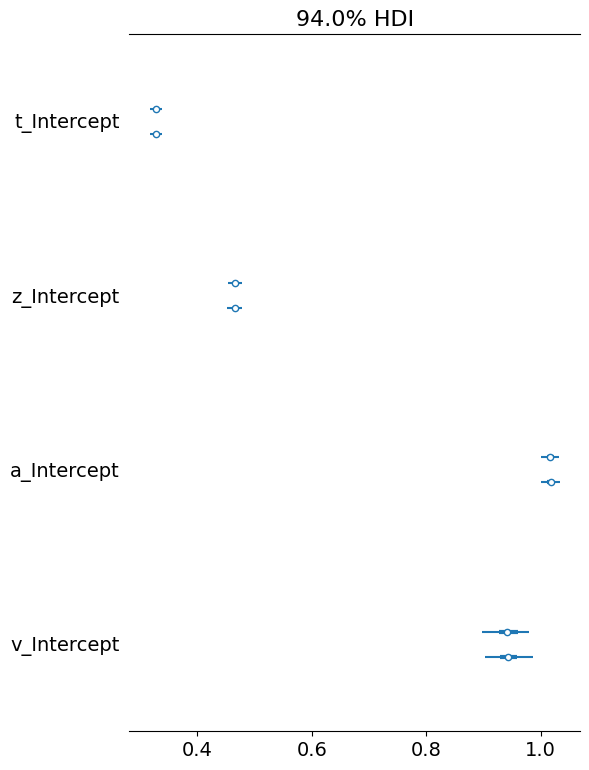

In [154]:
az.plot_forest(BasicDDMModel.traces)
plt.tight_layout()

array([[<Axes: ylabel='t_Intercept'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='z_Intercept'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='a_Intercept'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='t_Intercept', ylabel='v_Intercept'>,
        <Axes: xlabel='z_Intercept'>, <Axes: xlabel='a_Intercept'>,
        <Axes: xlabel='v_Intercept'>]], dtype=object)

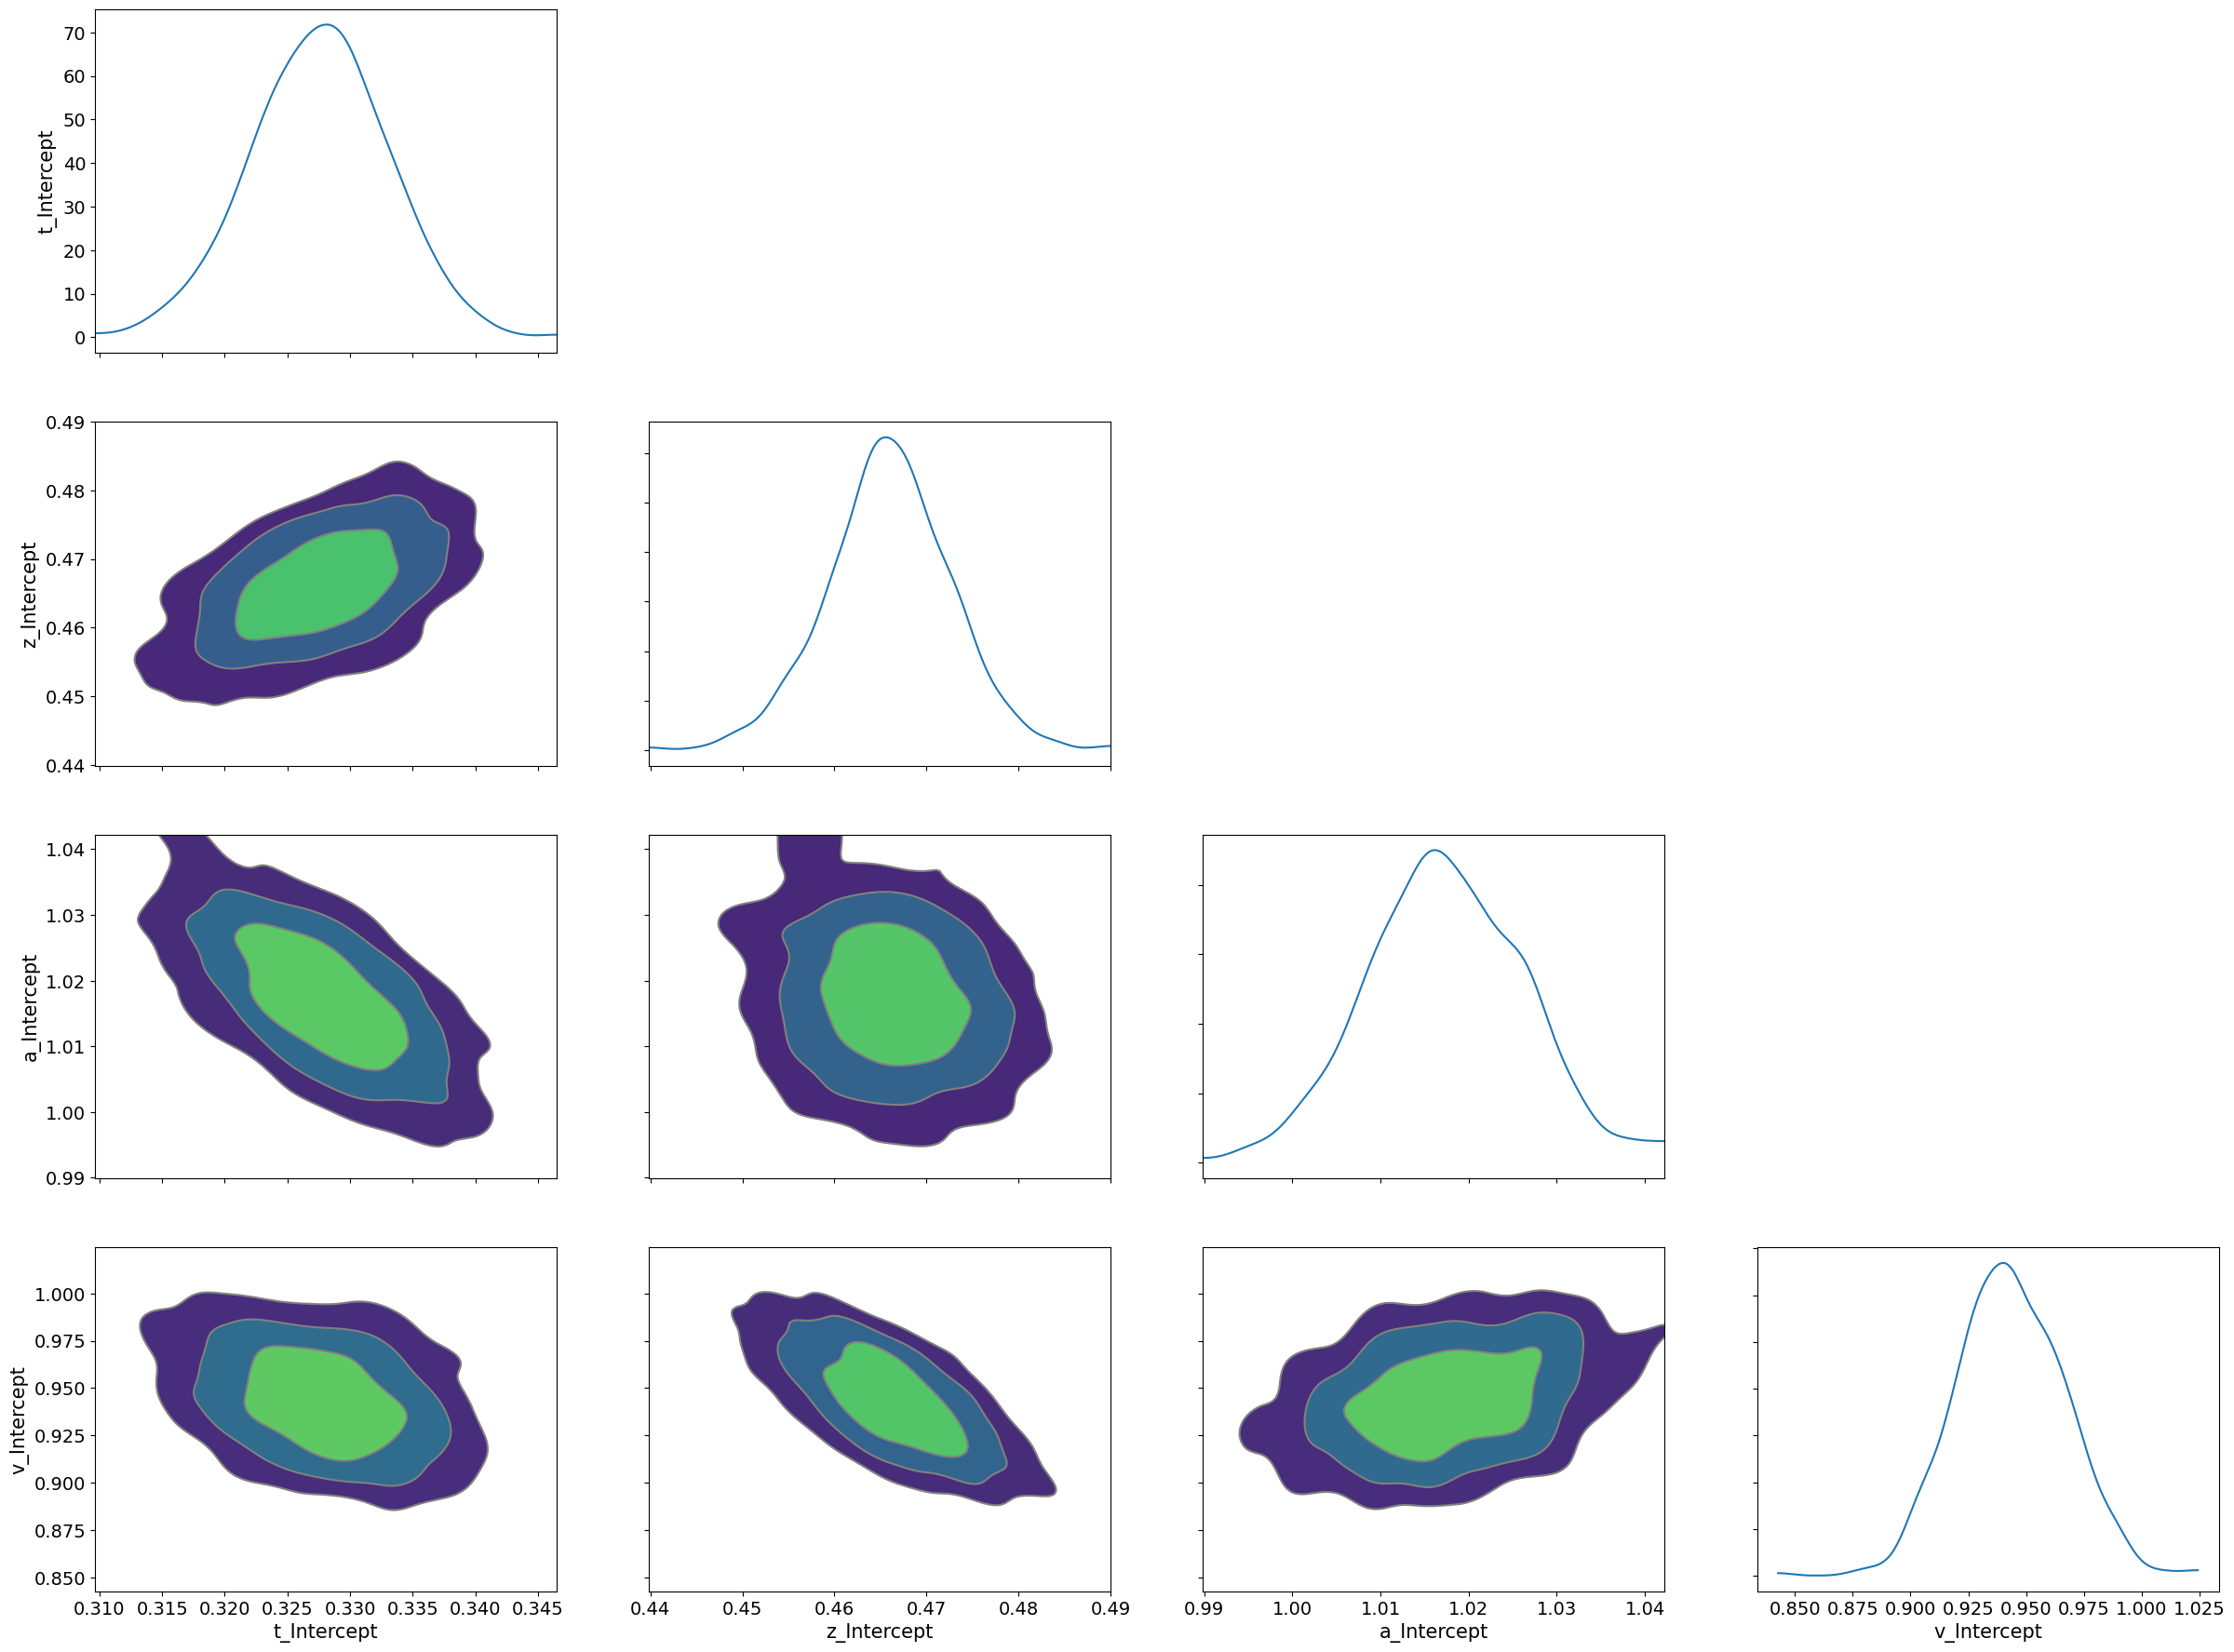

In [17]:
az.plot_pair(BasicDDMModel.traces,
             kind="kde",
             marginals=True)

No posterior predictive samples found. Generating posterior predictive samples using the provided InferenceData object and the original data. This will modify the provided InferenceData object, or if not provided, the traces object stored inside the model.


Output()

Output()

Output()

Output()

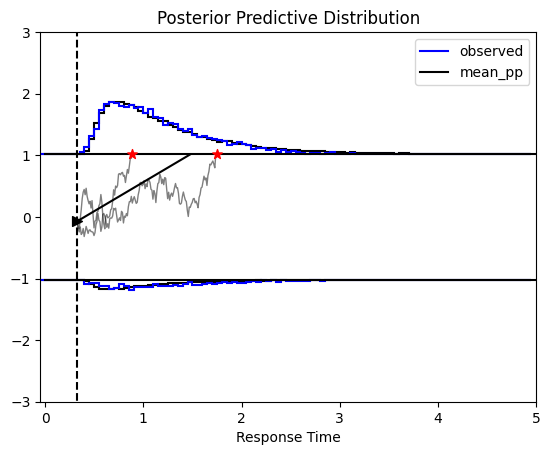

In [18]:
ax = hssm.plotting.plot_model_cartoon(
    BasicDDMModel,
    n_samples=10,
    bins=20,
    plot_pp_mean=True,
    plot_pp_samples=False,
    n_trajectories=2,  # extra arguments for the underlying plot_model_cartoon() function
);

/Users/afengler/Library/CloudStorage/OneDrive-Personal/proj_hssm/HSSM/src/hssm/plotting/utils.py:327: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["observed", "chain", "draw", cond, "is_correct"])["rt"]
/Users/afengler/Library/CloudStorage/OneDrive-Personal/proj_hssm/HSSM/src/hssm/plotting/utils.py:334: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["observed", "chain", "draw", cond])["is_correct"]


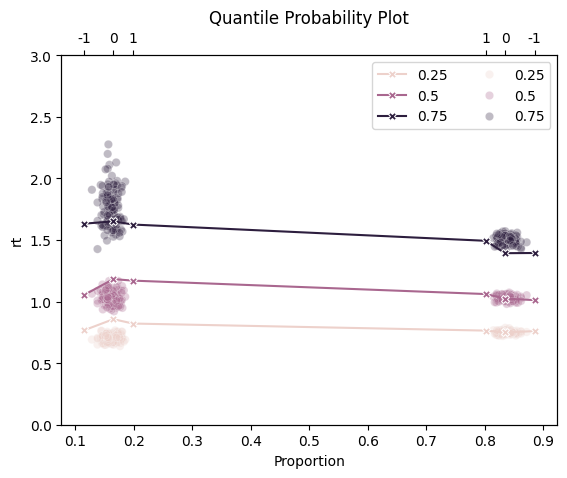

In [19]:
ax = hssm.plotting.plot_quantile_probability(BasicDDMModel, 
                                             cond="quantile_difficulty",
                                             )
ax.set_ylim(0, 3);
# ax.set_xlim(-0.1, 1.1);

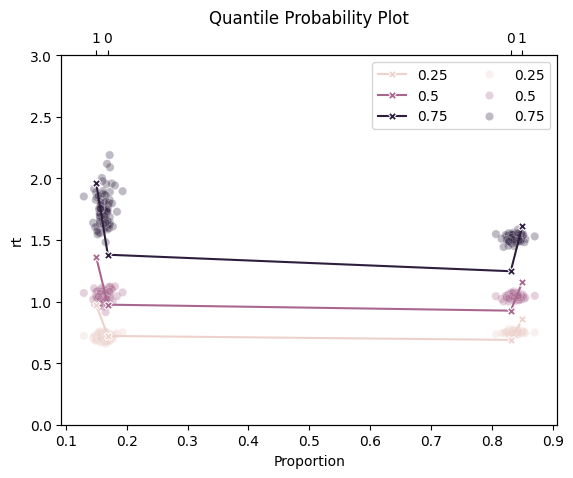

In [20]:
ax = hssm.plotting.plot_quantile_probability(BasicDDMModel, 
                                             cond="costly_fail_condition",
                                             )
ax.set_ylim(0, 3);

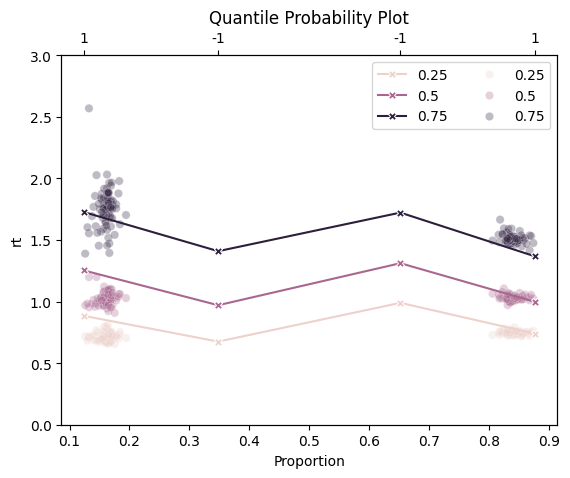

In [67]:
ax = hssm.plotting.plot_quantile_probability(BasicDDMModel, 
                                             cond="response_l1_plotting",
                                             )
ax.set_ylim(0, 3);

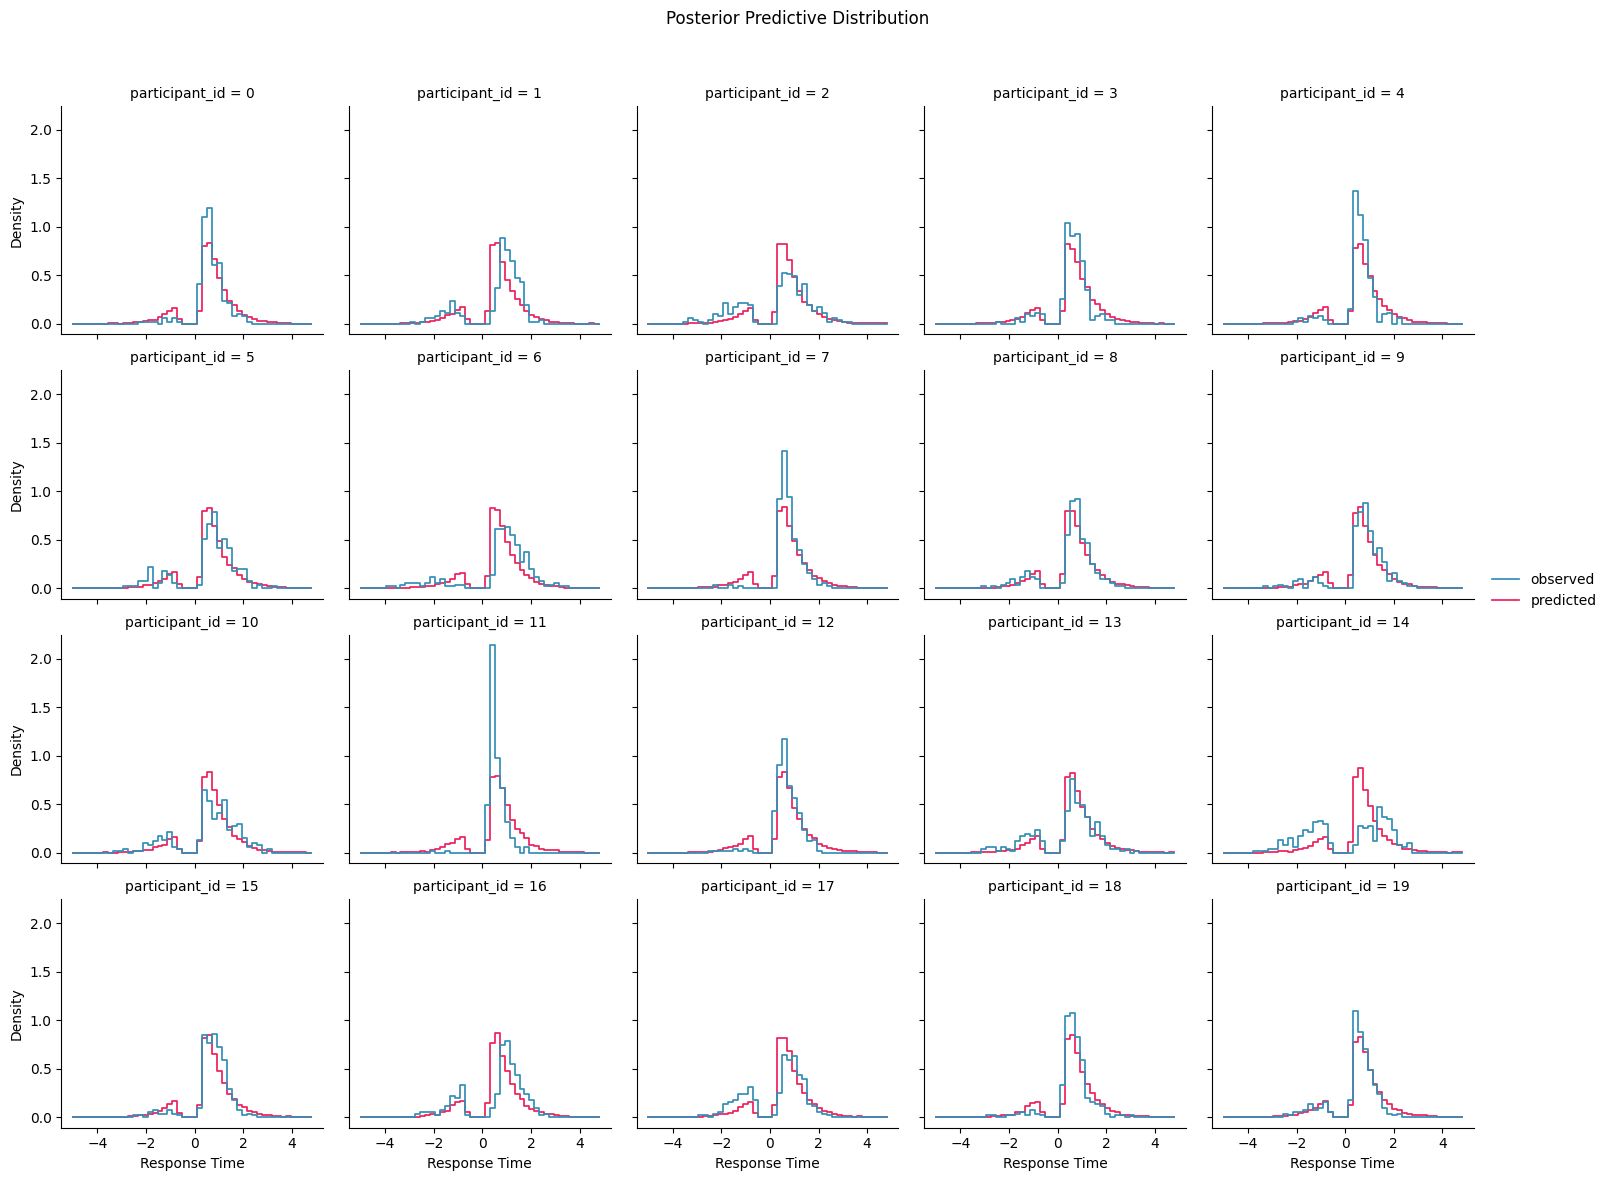

In [ ]:
# Posterior predictive
BasicDDMModel.plot_posterior_predictive(step = True, 
                                        col = 'participant_id',
                                        col_wrap = 5,
                                        bins = np.linspace(-5,5, 50))

### DDM Hierarchical

In [ ]:
DDMHierModel = hssm.HSSM(data = workshop_data,
                         model = "ddm",
                         loglik_kind = "approx_differentiable",
                         global_formula = "y ~ (1|participant_id)", # New
                         noncentered = False,
                        )

Model initialized successfully.


In [24]:
try:
    # Load pre-computed traces
    DDMHierModel.restore_traces(traces = "idata/ddm_hier/traces.nc")
except:
    # Sample posterior
    ddm_hier_idata = DDMHierModel.sample(chains = 2,
                                             sampler = "nuts_numpyro",
                                             tune = 500,
                                             draws = 500,
                                            )

    # Sample posterior predictive
    DDMHierModel.sample_posterior_predictive(draws = 200,
                                             safe_mode = True)

    # Save Model
    DDMHierModel.save_model(model_name = "ddm_hier",
                              allow_absolute_base_path = True,
                              base_path = "idata/",
                              save_idata_only = True)

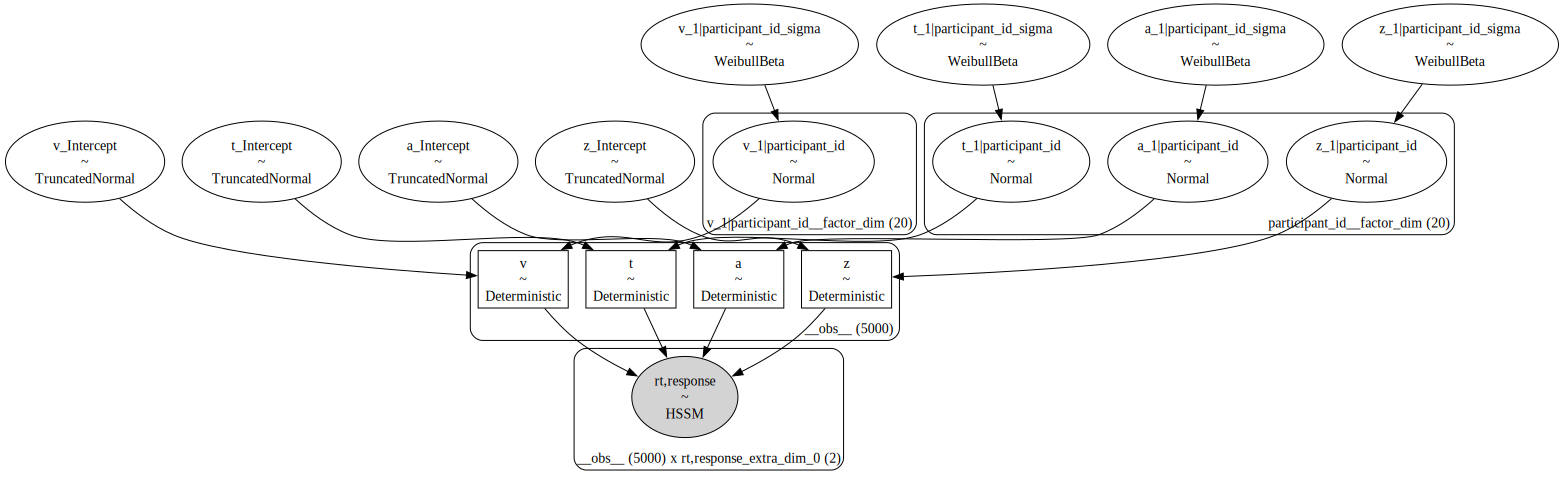

In [25]:
DDMHierModel.graph()

No posterior predictive samples found. Generating posterior predictive samples using the provided InferenceData object and the original data. This will modify the provided InferenceData object, or if not provided, the traces object stored inside the model.


Output()

Output()

Output()

Output()

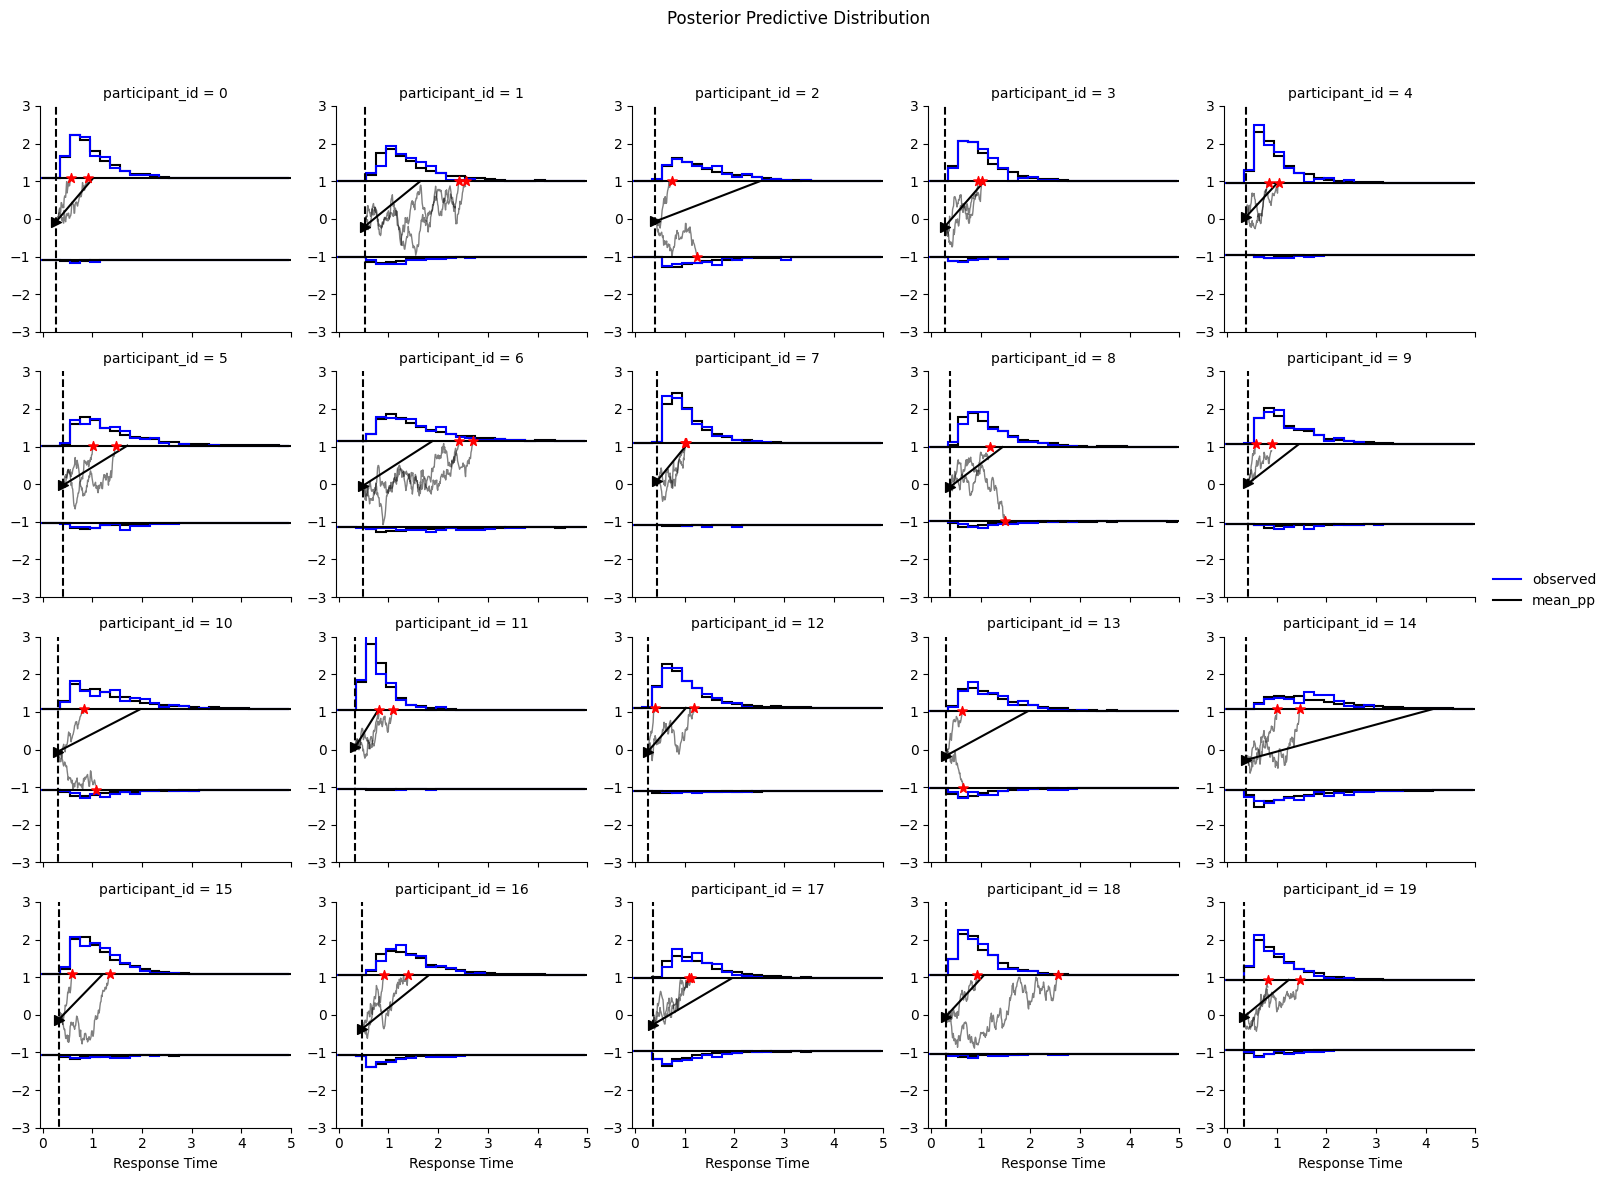

In [27]:
ax = hssm.plotting.plot_model_cartoon(
    DDMHierModel,
    col = "participant_id",
    col_wrap = 5,
    n_samples=100,
    bin_size=0.2,
    plot_pp_mean=True,
    # color_pp_mean = "red",
    # color_pp = "black",
    plot_pp_samples=False,
    n_trajectories=2,  # extra arguments for the underlying plot_model_cartoon() function
);

In [28]:
az.summary(DDMHierModel.traces,
           filter_vars = "like",
           var_names = ["~participant_id"]).sort_index()

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
a_Intercept  1.041  0.019   1.005    1.078      0.001    0.001     311.0   
t_Intercept  0.375  0.021   0.337    0.414      0.002    0.002      89.0   
v_Intercept  0.948  0.110   0.734    1.146      0.010    0.006     121.0   
z_Intercept  0.455  0.016   0.424    0.485      0.001    0.001     190.0   

             ess_tail  r_hat  
a_Intercept     398.0   1.01  
t_Intercept     121.0   1.01  
v_Intercept     205.0   1.01  
z_Intercept     259.0   1.01

In [29]:
az.summary(BasicDDMModel.traces).sort_index()

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
a_Intercept  1.017  0.009   1.000    1.033      0.000    0.000     583.0   
t_Intercept  0.328  0.005   0.317    0.338      0.000    0.000     576.0   
v_Intercept  0.943  0.023   0.900    0.985      0.001    0.001     536.0   
z_Intercept  0.466  0.007   0.453    0.478      0.000    0.000     529.0   

             ess_tail  r_hat  
a_Intercept     610.0    1.0  
t_Intercept     573.0    1.0  
v_Intercept     526.0    1.0  
z_Intercept     496.0    1.0

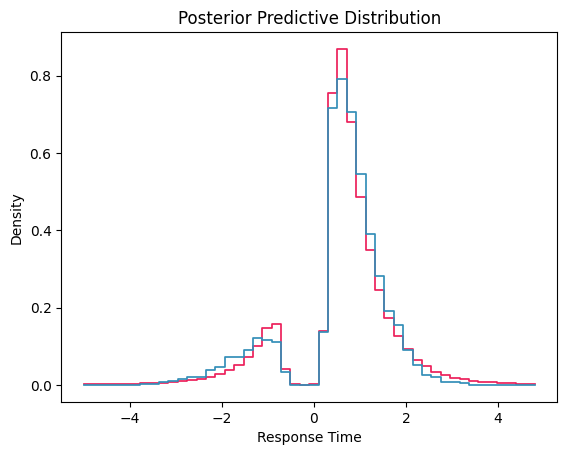

In [156]:
# Posterior predictive
DDMHierModel.plot_posterior_predictive(step = True, 
                                       col_wrap = 5,
                                       bins = np.linspace(-5,5, 50));

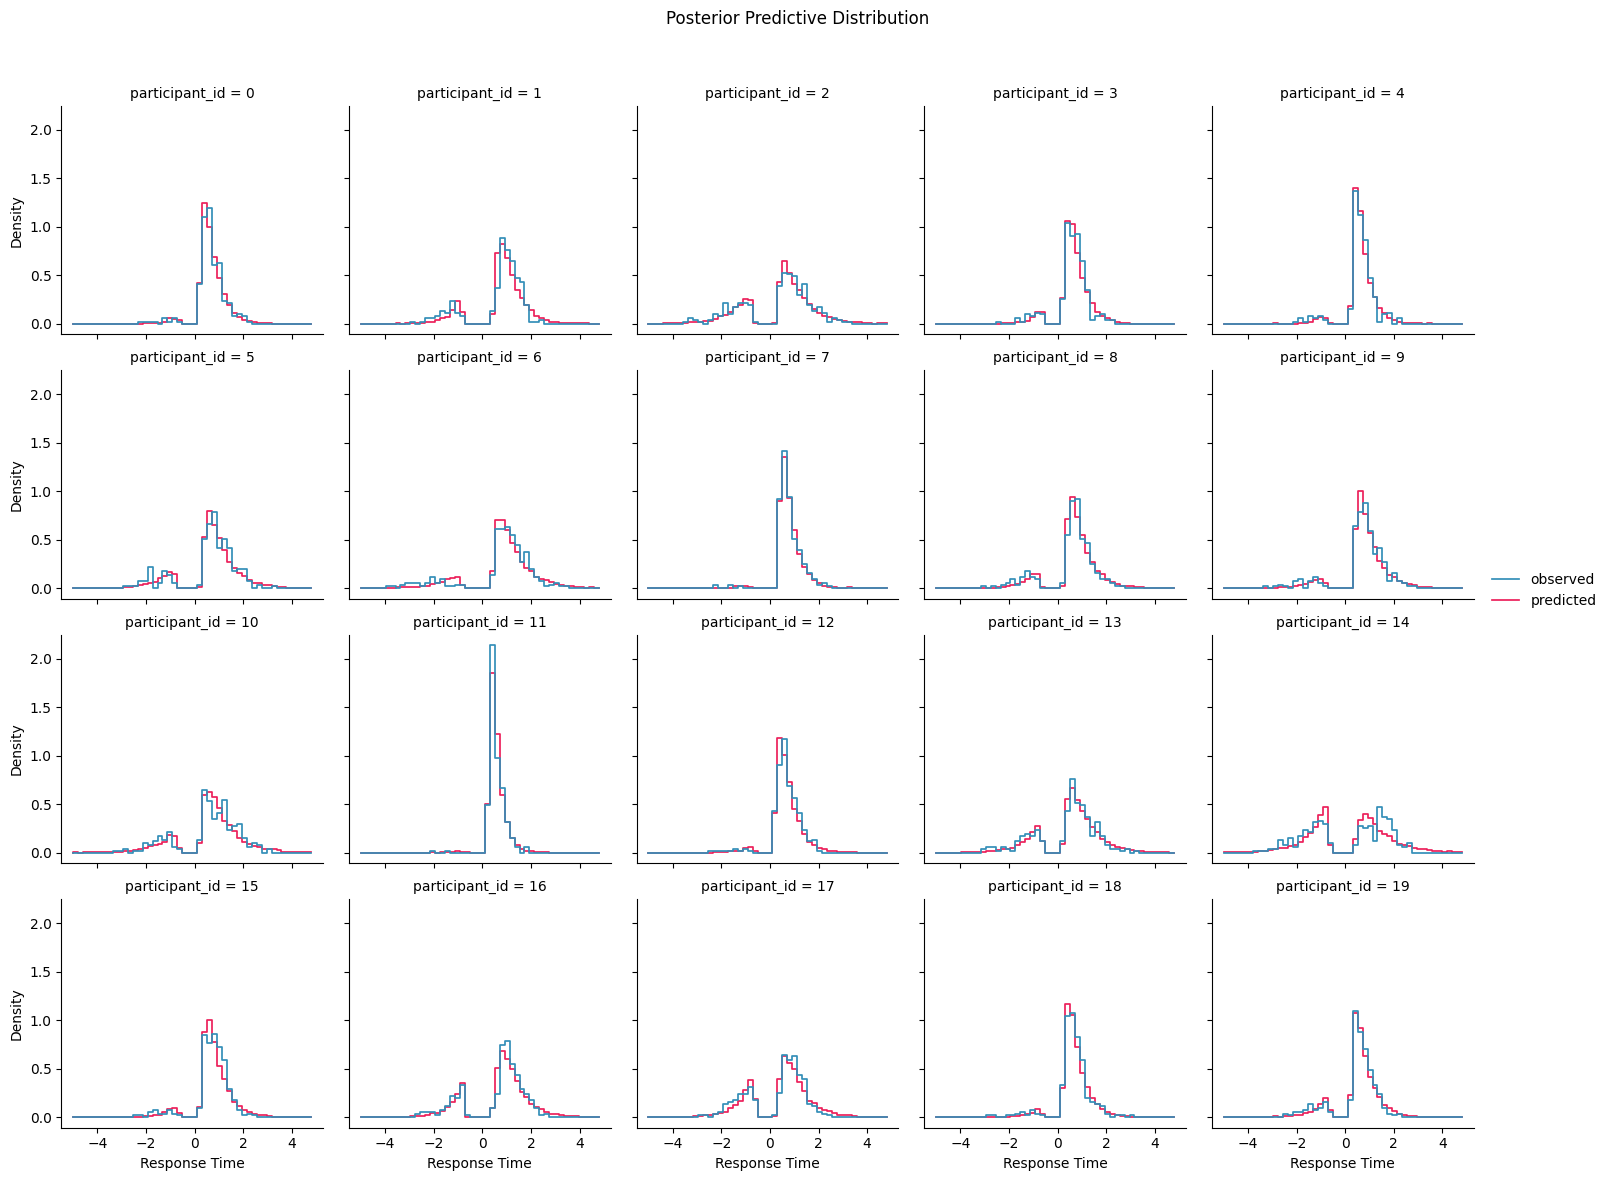

In [30]:
# Posterior predictive
DDMHierModel.plot_posterior_predictive(step = True, 
                                       col = 'participant_id',
                                       col_wrap = 5,
                                       bins = np.linspace(-5,5, 50))

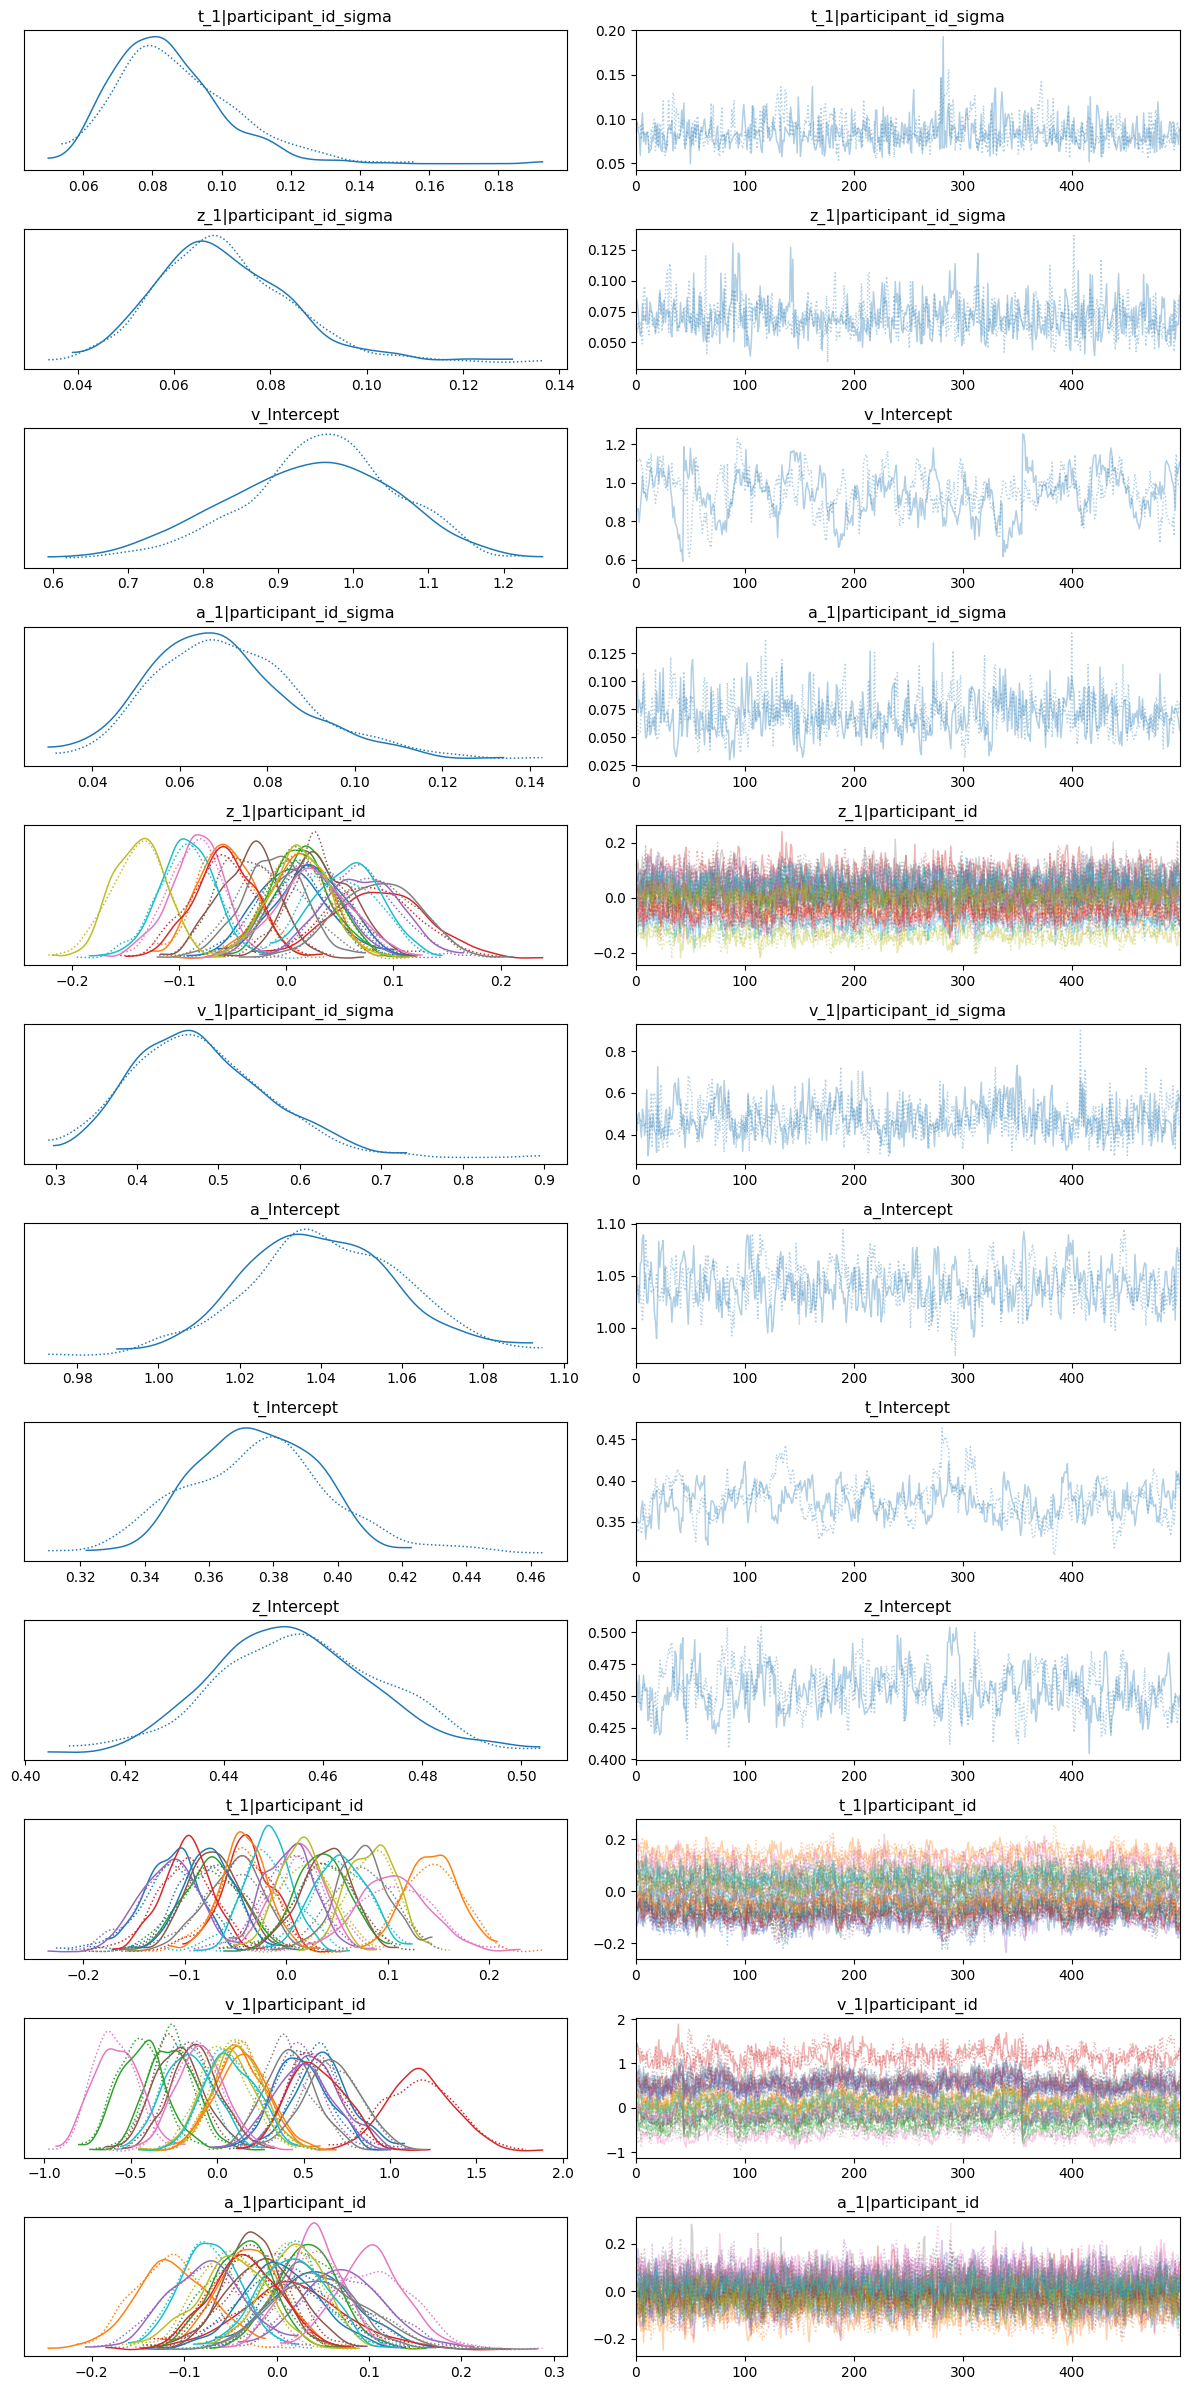

In [31]:
az.plot_trace(DDMHierModel.traces)
plt.tight_layout()

In [32]:
az.compare(
    {"DDM": BasicDDMModel.traces, "DDM Hierarchical": DDMHierModel.traces}
)

/Users/afengler/Library/CloudStorage/OneDrive-Personal/proj_hssm/HSSM/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.67 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


rank     elpd_loo      p_loo   elpd_diff    weight  \
DDM Hierarchical     0 -4954.407753  74.496783    0.000000  0.999617   
DDM                  1 -5645.531361   4.771162  691.123609  0.000383   

                         se        dse  warning scale  
DDM Hierarchical  76.438410   0.000000     True   log  
DDM               74.728599  32.604471    False   log

### ANGLE Hierarchical

In [ ]:
AngleHierModel = hssm.HSSM(data = workshop_data,
                           model = "angle",
                           loglik_kind = "approx_differentiable",
                           global_formula = "y ~ (1|participant_id)",
                           noncentered = False,
                          )

Model initialized successfully.


In [34]:
try:
    # Load pre-computed traces
    AngleHierModel.restore_traces(traces = "idata/angle_hier/traces.nc")
except:
    # Sample posterior
    angle_hier_idata = AngleHierModel.sample(chains = 2,
                                             sampler = "nuts_numpyro",
                                             tune = 500,
                                             draws = 500,
                                            )

    # Sample posterior predictive
    AngleHierModel.sample_posterior_predictive(draws = 200,
                                               safe_mode = True)

    # Save Model
    AngleHierModel.save_model(model_name = "angle_hier",
                              allow_absolute_base_path = True,
                              base_path = "idata/",
                              save_idata_only = True)

No posterior predictive samples found. Generating posterior predictive samples using the provided InferenceData object and the original data. This will modify the provided InferenceData object, or if not provided, the traces object stored inside the model.


Output()

Output()

Output()

Output()

Output()

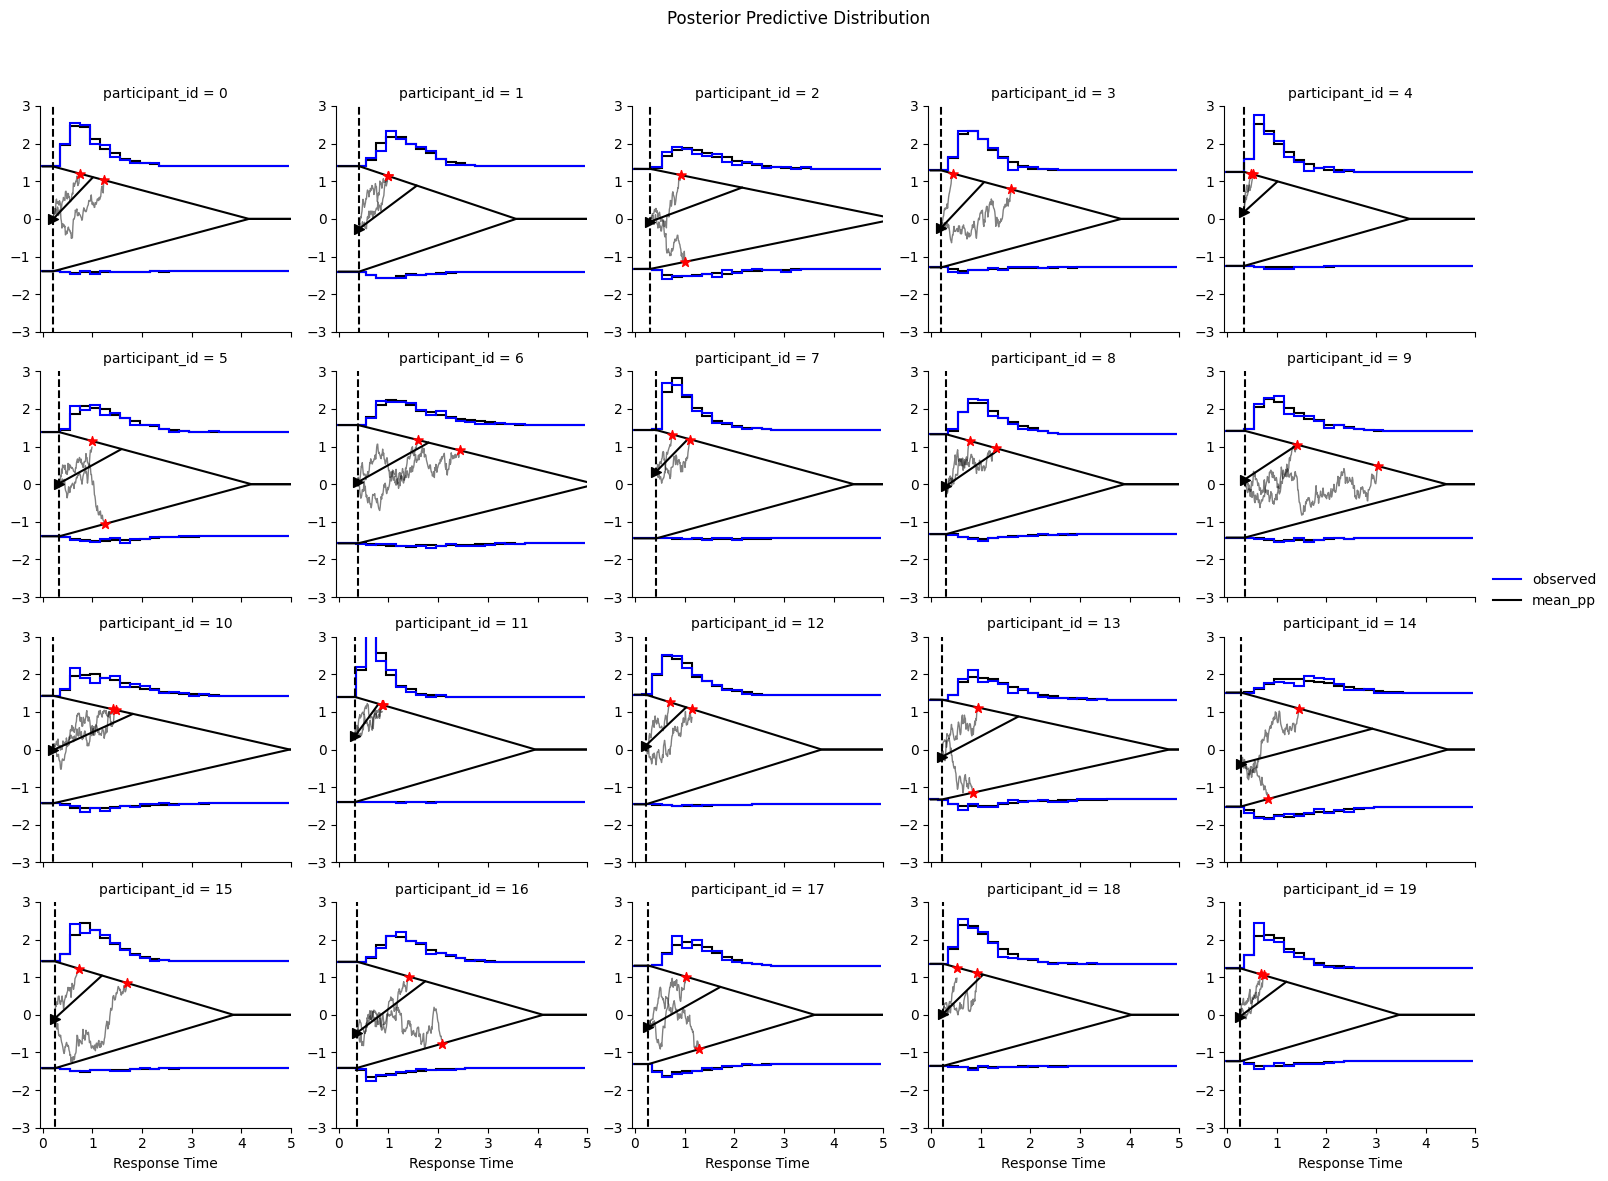

In [36]:
ax = hssm.plotting.plot_model_cartoon(
    AngleHierModel,
    col = 'participant_id',
    col_wrap = 5,
    n_samples=10,
    bin_size=0.2,
    plot_pp_mean=True,
    plot_pp_samples=False,
    n_trajectories=2,  # extra arguments for the underlying plot_model_cartoon() function
);

<Axes: title={'center': 'Posterior Predictive Distribution'}, xlabel='Response Time', ylabel='Density'>

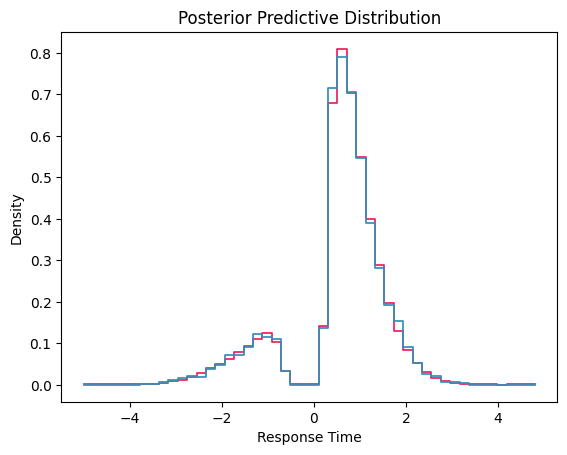

In [157]:
# Posterior predictive
AngleHierModel.plot_posterior_predictive(step = True, 
                                         col_wrap = 5,
                                         bins = np.linspace(-5,5, 50))

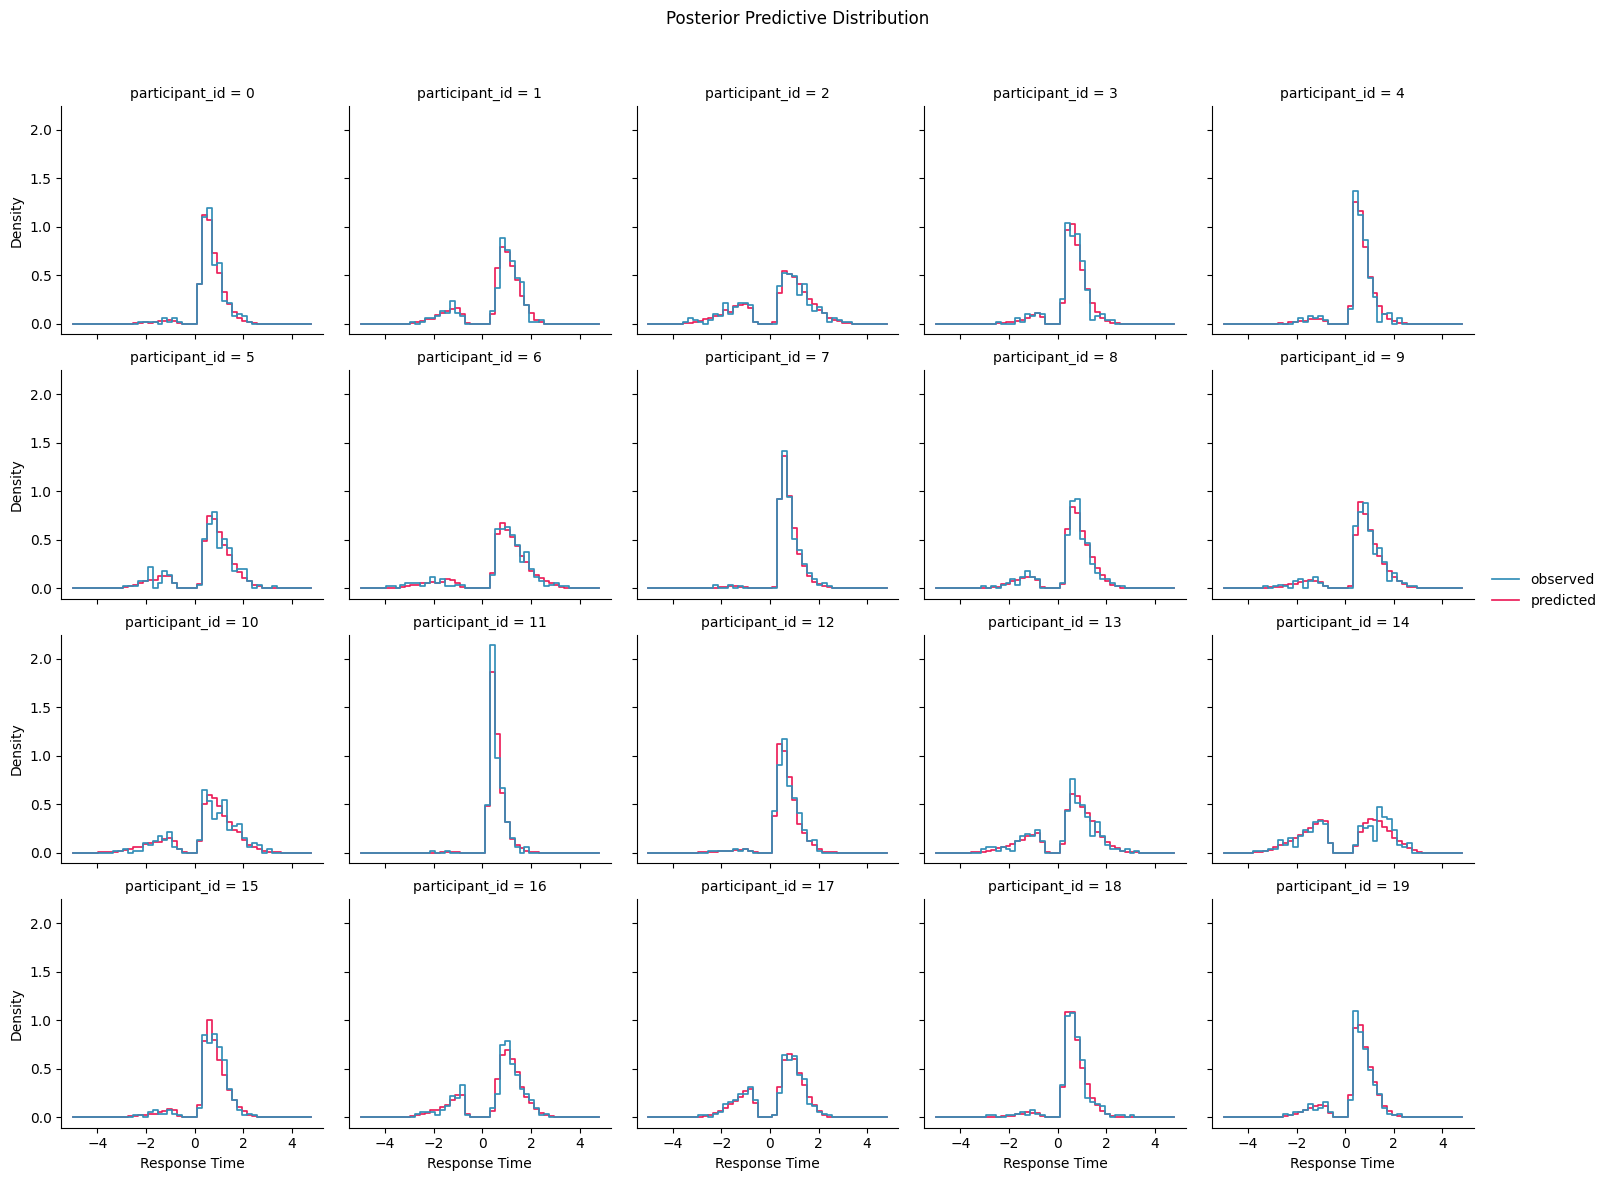

In [37]:
# Posterior predictive
AngleHierModel.plot_posterior_predictive(step = True, 
                                        col = 'participant_id',
                                        col_wrap = 5,
                                        bins = np.linspace(-5,5, 50))

In [38]:
az.compare(
    {"DDM": BasicDDMModel.traces,
     "DDM Hierarchical": DDMHierModel.traces,
     "Angle Hierarchical": AngleHierModel.traces}
)

/Users/afengler/Library/CloudStorage/OneDrive-Personal/proj_hssm/HSSM/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.67 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


rank     elpd_loo      p_loo   elpd_diff        weight  \
Angle Hierarchical     0 -4736.169362  78.314263    0.000000  1.000000e+00   
DDM Hierarchical       1 -4954.407753  74.496783  218.238391  1.224752e-07   
DDM                    2 -5645.531361   4.771162  909.361999  0.000000e+00   

                           se        dse  warning scale  
Angle Hierarchical  72.823694   0.000000    False   log  
DDM Hierarchical    76.438410  16.444095     True   log  
DDM                 74.728599  36.363183    False   log

### Further EDA

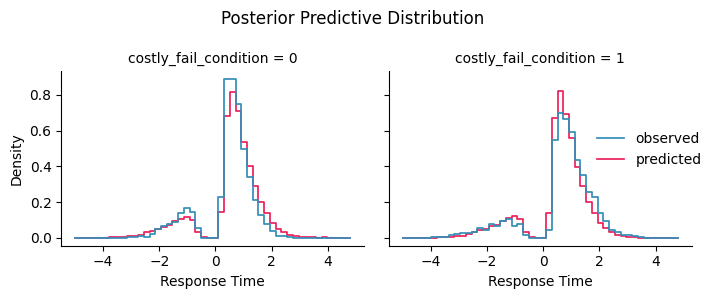

In [158]:
# Posterior predictive
AngleHierModel.plot_posterior_predictive(step = True, 
                                         col = 'costly_fail_condition',
                                         bins = np.linspace(-5,5, 50))
plt.tight_layout()

### Addressing costly fail condition

In [40]:
AngleHierModelV2 = hssm.HSSM(data = workshop_data,
                             model = "angle",
                             loglik_kind = "approx_differentiable",
                             global_formula = "y ~ (1|participant_id)",
                             include = [{"name": "a",
                                         "formula": "a ~ (1 + C(costly_fail_condition)|participant_id)"}],
                             noncentered = False,
                            )

Model initialized successfully.


In [41]:
try:
    # Load pre-computed traces
    AngleHierModelV2.restore_traces(traces = "idata/angle_hier_v2/traces.nc")
except:
    # Sample posterior
    angle_hier_idata = AngleHierModelV2.sample(chains = 2,
                                             sampler = "nuts_numpyro",
                                             tune = 500,
                                             draws = 500,
                                            )

    # Sample posterior predictive
    AngleHierModelV2.sample_posterior_predictive(draws = 200,
                                                 safe_mode = True)

    # Save Model
    AngleHierModelV2.save_model(model_name = "angle_hier_v2",
                                allow_absolute_base_path = True,
                                base_path = "idata/",
                                save_idata_only = True)

In [42]:
az.compare(
    {"DDM": BasicDDMModel.traces,
     "DDM Hierarchical": DDMHierModel.traces,
     "Angle Hierarchical": AngleHierModel.traces,
     "Angle Hierarchical Cost": AngleHierModelV2.traces}
)

/Users/afengler/Library/CloudStorage/OneDrive-Personal/proj_hssm/HSSM/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.67 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


rank     elpd_loo      p_loo    elpd_diff  \
Angle Hierarchical Cost     0 -4470.826272  87.516854     0.000000   
Angle Hierarchical          1 -4736.169362  78.314263   265.343090   
DDM Hierarchical            2 -4954.407753  74.496783   483.581480   
DDM                         3 -5645.531361   4.771162  1174.705089   

                               weight         se        dse  warning scale  
Angle Hierarchical Cost  1.000000e+00  70.898643   0.000000    False   log  
Angle Hierarchical       0.000000e+00  72.823694  20.493383    False   log  
DDM Hierarchical         2.494250e-12  76.438410  25.173534     True   log  
DDM                      0.000000e+00  74.728599  40.610196    False   log

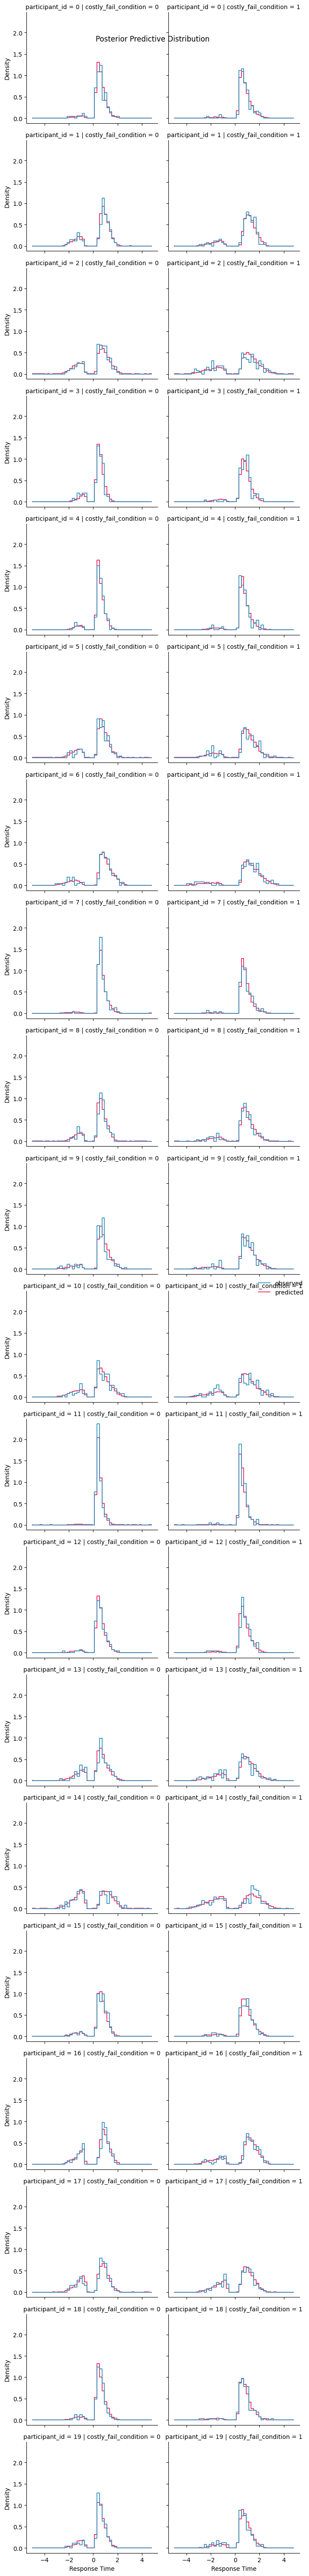

In [ ]:
# Posterior predictive
AngleHierModelV2.plot_posterior_predictive(step = True, 
                                           row = 'participant_id',
                                           col = 'costly_fail_condition',
                                           #  groups = 'costly_fail_condition',
                                           #  col_wrap = 5,
                                           bins = np.linspace(-5,5, 50))
plt.tight_layout()

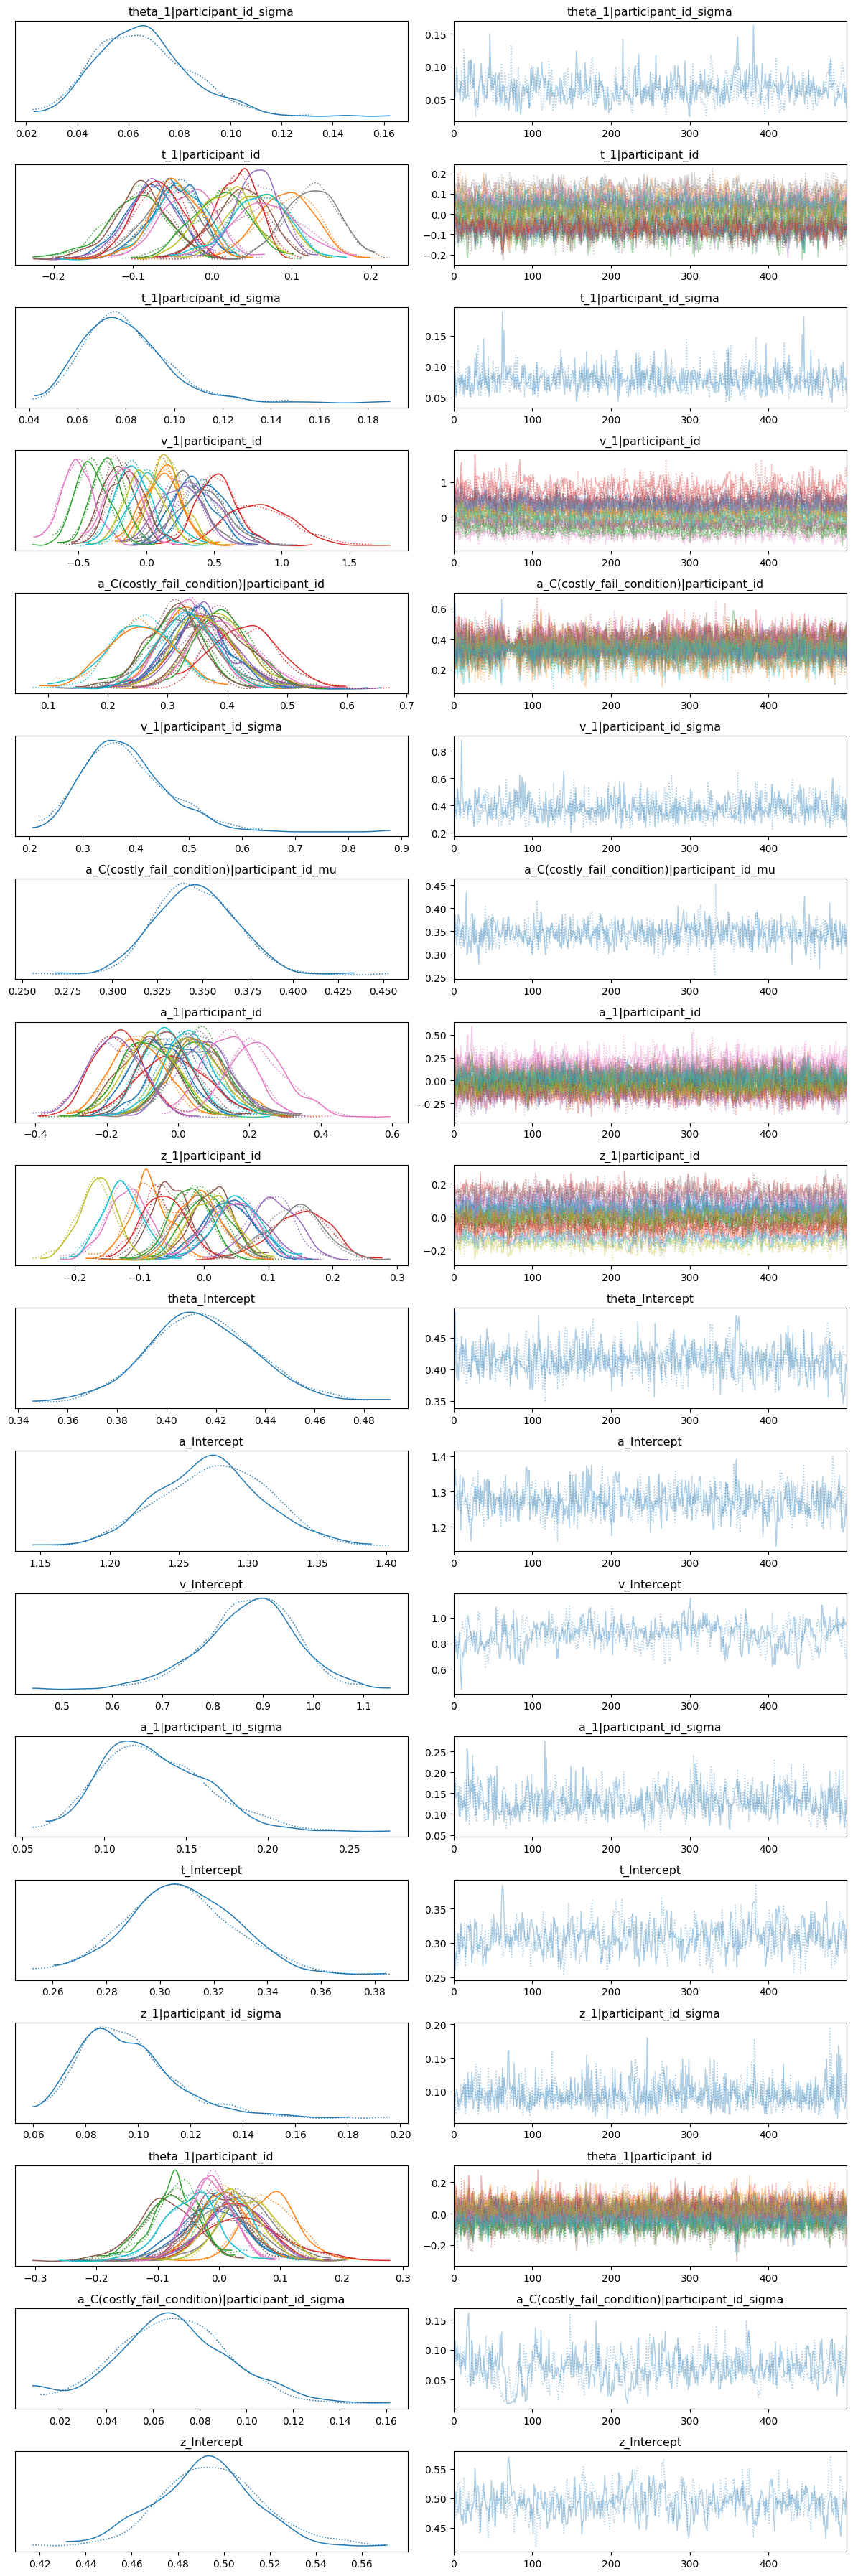

In [44]:
az.plot_trace(AngleHierModelV2.traces)
plt.tight_layout()

<Axes: title={'center': 'a_C(costly_fail_condition)|participant_id_mu\n1'}>

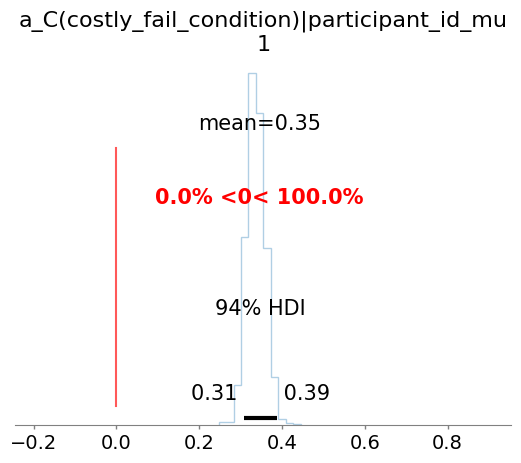

In [45]:
az.plot_posterior(AngleHierModelV2.traces,
                  var_names = ["a_C(costly_fail_condition)|participant_id_mu"],
                  ref_val = 0,
                  kind = "hist",
                  ref_val_color = "red",
                  histtype = "step")

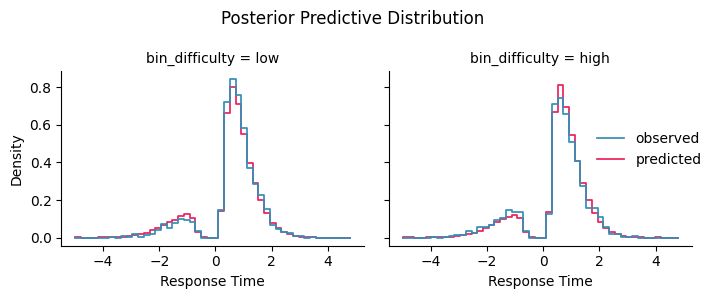

In [46]:
# Posterior predictive
AngleHierModelV2.plot_posterior_predictive(step = True, 
                                           # row = 'participant_id',
                                           col = 'bin_difficulty',
                                           bins = np.linspace(-5, 5, 50),
                                           )
plt.tight_layout()
plt.show()

### Addressing difficulty

In [47]:
AngleHierModelV3 = hssm.HSSM(data = workshop_data,
                             model = "angle",
                             loglik_kind = "approx_differentiable",
                             global_formula = "y ~ (1|participant_id)",
                             include = [{"name": "a",
                                         "formula": "a ~ (1 + C(costly_fail_condition)|participant_id)"},
                                         {"name": "v",
                                          "formula": "v ~ (1 + continuous_difficulty|participant_id)"},
                                          ],
                             noncentered = False,
                            )

Model initialized successfully.


In [48]:
try:
    # Load pre-computed traces
    AngleHierModelV3.restore_traces(traces = "idata/angle_hier_v3/traces.nc")
except:
    # Sample posterior
    angle_hier_idata = AngleHierModelV3.sample(chains = 2,
                                             sampler = "nuts_numpyro",
                                             tune = 500,
                                             draws = 500,
                                            )

    # Sample posterior predictive
    AngleHierModelV3.sample_posterior_predictive(draws = 200,
                                                 safe_mode = True)

    # Save Model
    AngleHierModelV3.save_model(model_name = "angle_hier_v3",
                                allow_absolute_base_path = True,
                                base_path = "idata/",
                                save_idata_only = True)

<Axes: title={'center': 'v_continuous_difficulty|participant_id_mu'}>

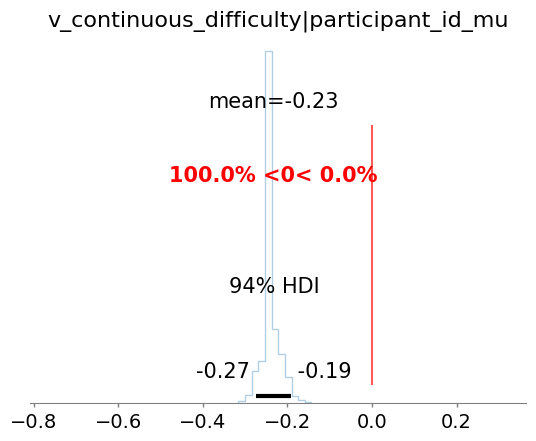

In [49]:
az.plot_posterior(AngleHierModelV3.traces,
                  var_names = ["v_continuous_difficulty|participant_id_mu"],
                  ref_val = 0,
                  kind = "hist",
                  ref_val_color = "red",
                  histtype = "step")

In [50]:
az.compare(
    {"DDM": BasicDDMModel.traces,
     "DDM Hierarchical": DDMHierModel.traces,
     "Angle Hierarchical": AngleHierModel.traces,
     "Angle Hierarchical Cost": AngleHierModelV2.traces,
     "Angle Hierarchical Cost/Diff": AngleHierModelV3.traces}
)

/Users/afengler/Library/CloudStorage/OneDrive-Personal/proj_hssm/HSSM/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.67 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/afengler/Library/CloudStorage/OneDrive-Personal/proj_hssm/HSSM/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.67 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly

rank     elpd_loo      p_loo    elpd_diff  \
Angle Hierarchical Cost/Diff     0 -4425.940827  69.185385     0.000000   
Angle Hierarchical Cost          1 -4470.826272  87.516854    44.885445   
Angle Hierarchical               2 -4736.169362  78.314263   310.228535   
DDM Hierarchical                 3 -4954.407753  74.496783   528.466926   
DDM                              4 -5645.531361   4.771162  1219.590534   

                                weight         se        dse  warning scale  
Angle Hierarchical Cost/Diff  0.987446  70.554577   0.000000     True   log  
Angle Hierarchical Cost       0.012554  70.898643   9.559271    False   log  
Angle Hierarchical            0.000000  72.823694  22.959534    False   log  
DDM Hierarchical              0.000000  76.438410  27.593021     True   log  
DDM                           0.000000  74.728599  41.671983    False   log

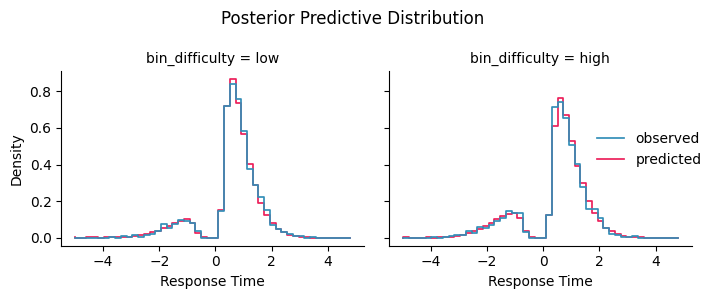

In [51]:
# Posterior predictive
AngleHierModelV3.plot_posterior_predictive(step = True, 
                                           col = 'bin_difficulty',
                                           bins = np.linspace(-5,5, 50))
plt.tight_layout()

### Anything else?

In [52]:
# Let's do a bit more eda

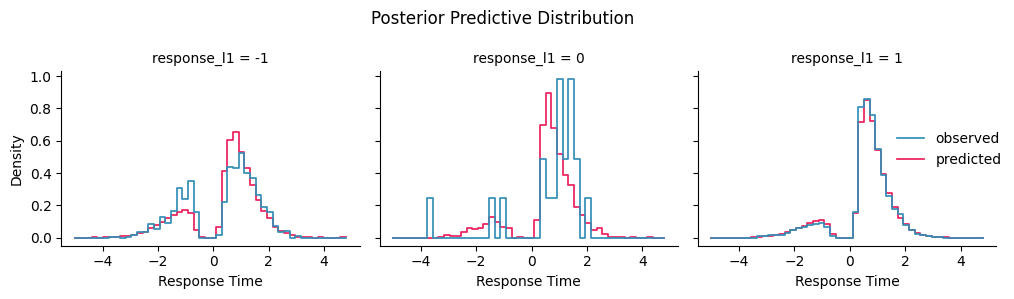

In [ ]:
# Posterior predictive
AngleHierModelV3.plot_posterior_predictive(step = True, 
                                           col = 'response_l1_plotting',
                                           bins = np.linspace(-5, 5, 50))
plt.tight_layout()

/Users/afengler/Library/CloudStorage/OneDrive-Personal/proj_hssm/HSSM/.venv/lib/python3.11/site-packages/numpy/lib/_histograms_impl.py:897: RuntimeWarning: invalid value encountered in divide
  return n / db / n.sum(), bin_edges
/Users/afengler/Library/CloudStorage/OneDrive-Personal/proj_hssm/HSSM/.venv/lib/python3.11/site-packages/numpy/lib/_histograms_impl.py:897: RuntimeWarning: invalid value encountered in divide
  return n / db / n.sum(), bin_edges
/Users/afengler/Library/CloudStorage/OneDrive-Personal/proj_hssm/HSSM/.venv/lib/python3.11/site-packages/numpy/lib/_histograms_impl.py:897: RuntimeWarning: invalid value encountered in divide
  return n / db / n.sum(), bin_edges
/Users/afengler/Library/CloudStorage/OneDrive-Personal/proj_hssm/HSSM/.venv/lib/python3.11/site-packages/numpy/lib/_histograms_impl.py:897: RuntimeWarning: invalid value encountered in divide
  return n / db / n.sum(), bin_edges
/Users/afengler/Library/CloudStorage/OneDrive-Personal/proj_hssm/HSSM/.venv/lib/pyth

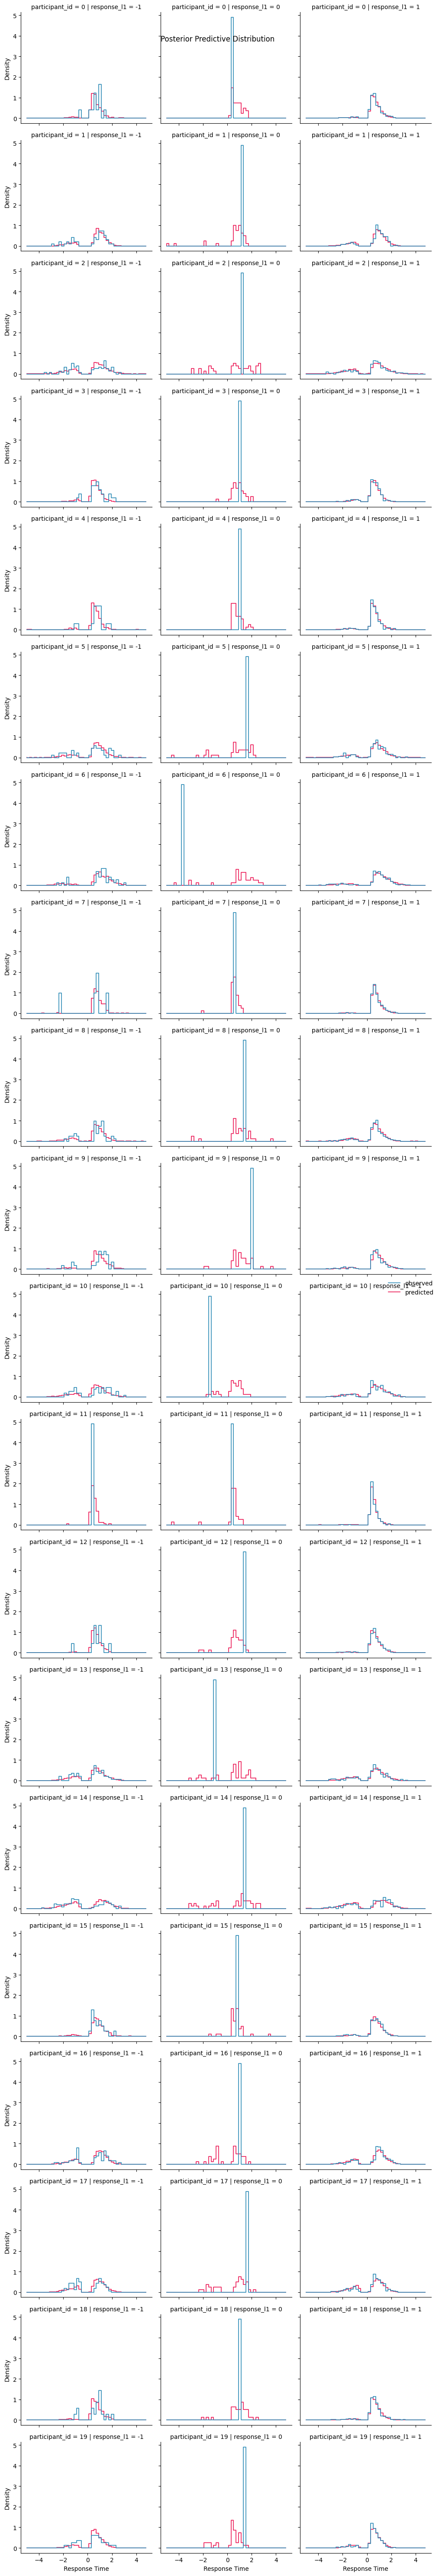

In [ ]:
# Posterior predictive
AngleHierModelV3.plot_posterior_predictive(step = True, 
                                           row = 'participant_id',
                                           col = 'response_l1_plotting',
                                           bins = np.linspace(-5, 5, 50))
plt.tight_layout()

### Addressing Stickyness

In [ ]:
AngleHierModelV4 = hssm.HSSM(data = workshop_data,
                             model = "angle",
                             loglik_kind = "approx_differentiable",
                             global_formula = "y ~ (1|participant_id)",
                             include = [{"name": "a",
                                         "formula": "a ~ (1 + C(costly_fail_condition)|participant_id)"},
                                         {"name": "v",
                                          "formula": "v ~ (1 + continuous_difficulty|participant_id)"},
                                         {"name": "z",
                                          "formula": "z ~ (1 + response_l1|participant_id)"},
                                        ],
                             noncentered = False,
                            )

Model initialized successfully.


In [56]:
try:
    # Load pre-computed traces
    AngleHierModelV4.restore_traces(traces = "idata/angle_hier_v4/traces.nc")
except:
    # Sample posterior
    angle_hier_idata = AngleHierModelV4.sample(chains = 2,
                                             sampler = "nuts_numpyro",
                                             tune = 500,
                                             draws = 500,
                                            )

    # Sample posterior predictive
    AngleHierModelV4.sample_posterior_predictive(draws = 200,
                                                 safe_mode = True)

    # Save Model
    AngleHierModelV4.save_model(model_name = "angle_hier_v4",
                                allow_absolute_base_path = True,
                                base_path = "idata/",
                                save_idata_only = True)

<Axes: title={'center': 'z_response_l1|participant_id_mu'}>

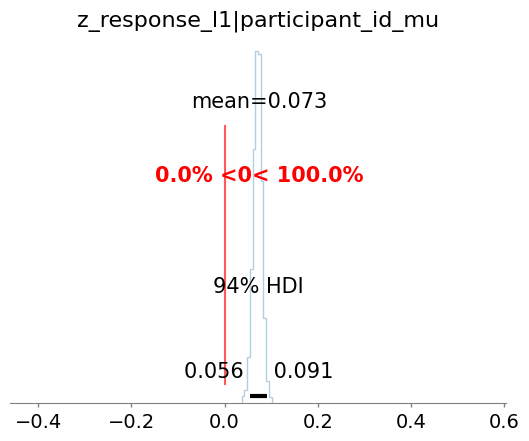

In [149]:
az.plot_posterior(AngleHierModelV4.traces,
                  var_names = ["z_response_l1|participant_id_mu"],
                  ref_val = 0,
                  kind = "hist",
                  ref_val_color = "red",
                  histtype = "step")

/Users/afengler/Library/CloudStorage/OneDrive-Personal/proj_hssm/HSSM/.venv/lib/python3.11/site-packages/numpy/lib/_histograms_impl.py:897: RuntimeWarning: invalid value encountered in divide
  return n / db / n.sum(), bin_edges
/Users/afengler/Library/CloudStorage/OneDrive-Personal/proj_hssm/HSSM/.venv/lib/python3.11/site-packages/numpy/lib/_histograms_impl.py:897: RuntimeWarning: invalid value encountered in divide
  return n / db / n.sum(), bin_edges
/Users/afengler/Library/CloudStorage/OneDrive-Personal/proj_hssm/HSSM/.venv/lib/python3.11/site-packages/numpy/lib/_histograms_impl.py:897: RuntimeWarning: invalid value encountered in divide
  return n / db / n.sum(), bin_edges
/Users/afengler/Library/CloudStorage/OneDrive-Personal/proj_hssm/HSSM/.venv/lib/python3.11/site-packages/numpy/lib/_histograms_impl.py:897: RuntimeWarning: invalid value encountered in divide
  return n / db / n.sum(), bin_edges
/Users/afengler/Library/CloudStorage/OneDrive-Personal/proj_hssm/HSSM/.venv/lib/pyth

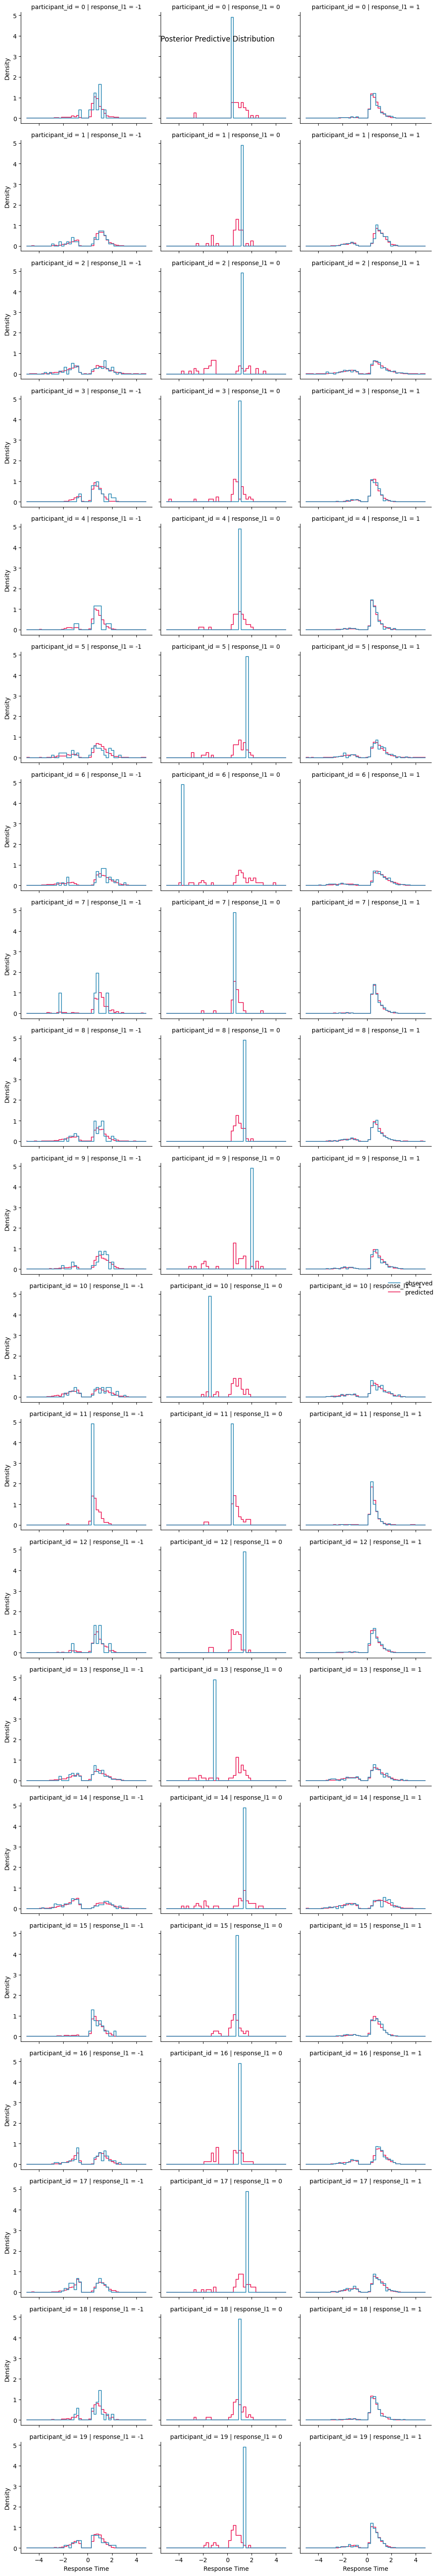

In [57]:
# Posterior predictive
AngleHierModelV4.plot_posterior_predictive(step = True, 
                                           row = 'participant_id',
                                           col = 'response_l1_plotting',
                                           bins = np.linspace(-5, 5, 50))
plt.tight_layout()

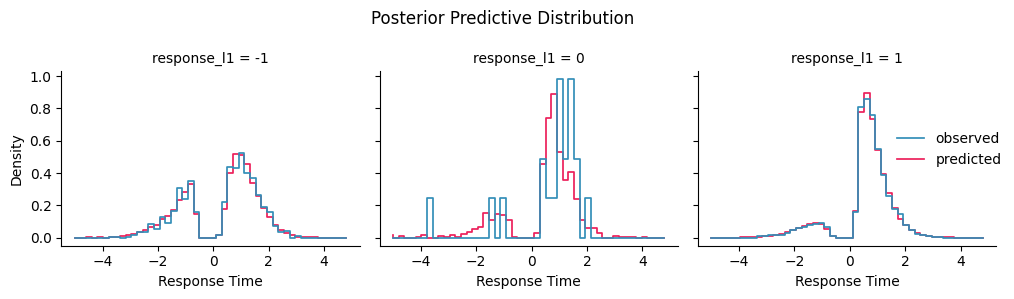

In [ ]:
# Posterior predictive
AngleHierModelV4.plot_posterior_predictive(step = True, 
                                           col = 'response_l1_plotting',
                                           #  groups = 'costly_fail_condition',
                                           #  col_wrap = 5,
                                           bins = np.linspace(-5,5, 50))
plt.tight_layout()

In [59]:
az.compare(
    {"DDM": BasicDDMModel.traces,
     "DDM Hierarchical": DDMHierModel.traces,
     "Angle Hierarchical": AngleHierModel.traces,
     "Angle Hierarchical Cost": AngleHierModelV2.traces,
     "Angle Hierarchical Cost/Diff": AngleHierModelV3.traces,
     "Angle Hierarchical Cost/Diff/Sticky": AngleHierModelV4.traces}
)

/Users/afengler/Library/CloudStorage/OneDrive-Personal/proj_hssm/HSSM/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.67 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/afengler/Library/CloudStorage/OneDrive-Personal/proj_hssm/HSSM/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.67 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly

rank     elpd_loo       p_loo  \
Angle Hierarchical Cost/Diff/Sticky     0 -4327.769237  103.455670   
Angle Hierarchical Cost/Diff            1 -4425.940827   69.185385   
Angle Hierarchical Cost                 2 -4470.826272   87.516854   
Angle Hierarchical                      3 -4736.169362   78.314263   
DDM Hierarchical                        4 -4954.407753   74.496783   
DDM                                     5 -5645.531361    4.771162   

                                       elpd_diff        weight         se  \
Angle Hierarchical Cost/Diff/Sticky     0.000000  9.181952e-01  71.004980   
Angle Hierarchical Cost/Diff           98.171590  8.180475e-02  70.554577   
Angle Hierarchical Cost               143.057036  4.715913e-09  70.898643   
Angle Hierarchical                    408.400125  4.891539e-09  72.823694   
DDM Hierarchical                      626.638516  3.069949e-09  76.438410   
DDM                                  1317.762125  0.000000e+00  74.728599   

                                           dse  warning scale  
Angle Hierarchical Cost/Diff/Sticky   0.000000    False   log  
Angle Hierarchical Cost/Diff         15.685768     True   log  
Angle Hierarchical Cost              17.113407    False   log  
Angle Hierarchical                   26.073429    False   log  
DDM Hierarchical                     29.304281     True   log  
DDM                                  43.174373    False   log

In [60]:
az.summary(AngleHierModelV4.traces, 
           var_names = ["response"], 
           filter_vars = "like")

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
z_response_l1|participant_id_mu     0.073  0.010   0.056    0.091      0.000   
z_response_l1|participant_id[0]     0.065  0.024   0.021    0.108      0.001   
z_response_l1|participant_id[1]     0.060  0.016   0.029    0.089      0.001   
z_response_l1|participant_id[10]    0.101  0.018   0.066    0.133      0.000   
z_response_l1|participant_id[11]    0.054  0.026   0.005    0.102      0.001   
z_response_l1|participant_id[12]    0.079  0.024   0.033    0.125      0.001   
z_response_l1|participant_id[13]    0.060  0.016   0.033    0.092      0.000   
z_response_l1|participant_id[14]    0.069  0.014   0.043    0.098      0.000   
z_response_l1|participant_id[15]    0.006  0.025  -0.040    0.052      0.001   
z_response_l1|participant_id[16]    0.069  0.015   0.044    0.097      0.001   
z_response_l1|participant_id[17]    0.105  0.016   0.080    0.136      0.001   
z_response_l1|participant_id[18]    0.087  0.023   0.048    0.131      0.001   
z_response_l1|participant_id[19]    0.102  0.017   0.073    0.136      0.001   
z_response_l1|participant_id[2]     0.086  0.015   0.060    0.113      0.000   
z_response_l1|participant_id[3]     0.072  0.021   0.028    0.107      0.001   
z_response_l1|participant_id[4]     0.092  0.022   0.050    0.130      0.001   
z_response_l1|participant_id[5]     0.041  0.018   0.008    0.075      0.001   
z_response_l1|participant_id[6]     0.057  0.021   0.017    0.097      0.001   
z_response_l1|participant_id[7]     0.089  0.027   0.040    0.142      0.001   
z_response_l1|participant_id[8]     0.083  0.017   0.054    0.115      0.001   
z_response_l1|participant_id[9]     0.085  0.020   0.052    0.125      0.001   
z_response_l1|participant_id_sigma  0.032  0.009   0.017    0.050      0.000   

                                    mcse_sd  ess_bulk  ess_tail  r_hat  
z_response_l1|participant_id_mu       0.000     431.0     624.0   1.00  
z_response_l1|participant_id[0]       0.001     345.0     742.0   1.01  
z_response_l1|participant_id[1]       0.001     952.0     423.0   1.01  
z_response_l1|participant_id[10]      0.001    1483.0     552.0   1.01  
z_response_l1|participant_id[11]      0.001     770.0     757.0   1.01  
z_response_l1|participant_id[12]      0.001     782.0     246.0   1.00  
z_response_l1|participant_id[13]      0.001    1696.0     624.0   1.02  
z_response_l1|participant_id[14]      0.001    2416.0     692.0   1.04  
z_response_l1|participant_id[15]      0.001    1174.0     838.0   1.01  
z_response_l1|participant_id[16]      0.001     283.0     257.0   1.01  
z_response_l1|participant_id[17]      0.001     487.0     558.0   1.00  
z_response_l1|participant_id[18]      0.001     566.0     740.0   1.02  
z_response_l1|participant_id[19]      0.001     821.0     427.0   1.00  
z_response_l1|participant_id[2]       0.000    1909.0     770.0   1.01  
z_response_l1|participant_id[3]       0.001     424.0     450.0   1.01  
z_response_l1|participant_id[4]       0.001     506.0     576.0   1.00  
z_response_l1|participant_id[5]       0.001    1123.0     786.0   1.00  
z_response_l1|participant_id[6]       0.001    1009.0     662.0   1.01  
z_response_l1|participant_id[7]       0.001     526.0     231.0   1.01  
z_response_l1|participant_id[8]       0.000     805.0     584.0   1.00  
z_response_l1|participant_id[9]       0.001    1220.0     755.0   1.01  
z_response_l1|participant_id_sigma    0.000     354.0     708.0   1.01

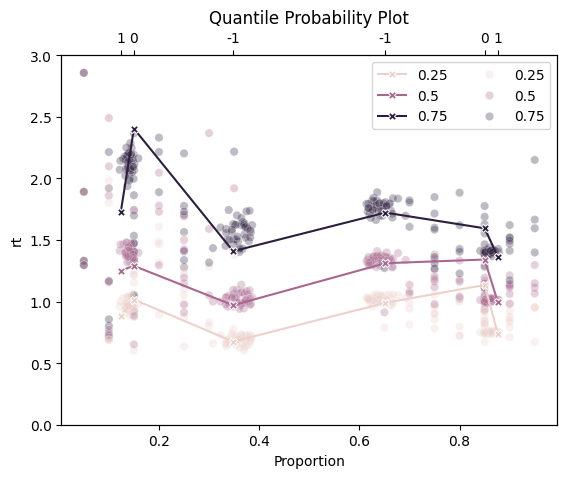

In [61]:
ax = hssm.plotting.plot_quantile_probability(AngleHierModelV4, 
                                             cond="response_l1",
                                             )
ax.set_ylim(0, 3);

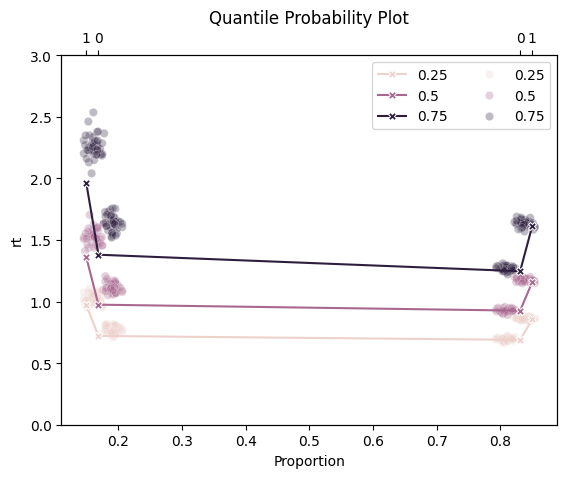

In [62]:
ax = hssm.plotting.plot_quantile_probability(AngleHierModelV4, 
                                             cond="costly_fail_condition",
                                             )
ax.set_ylim(0, 3);

/Users/afengler/Library/CloudStorage/OneDrive-Personal/proj_hssm/HSSM/src/hssm/plotting/utils.py:327: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["observed", "chain", "draw", cond, "is_correct"])["rt"]
/Users/afengler/Library/CloudStorage/OneDrive-Personal/proj_hssm/HSSM/src/hssm/plotting/utils.py:334: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["observed", "chain", "draw", cond])["is_correct"]


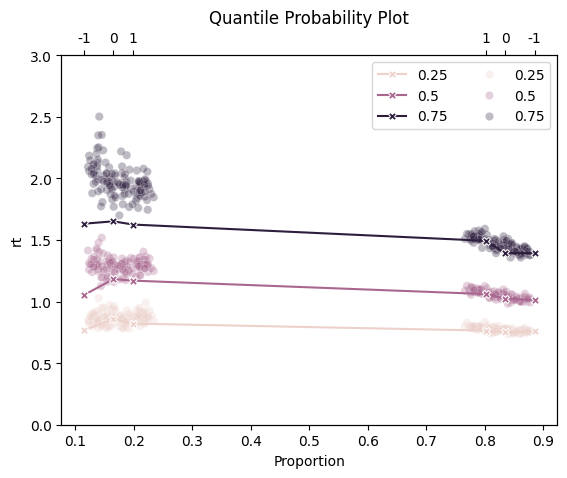

In [63]:
ax = hssm.plotting.plot_quantile_probability(AngleHierModelV4, 
                                             cond="quantile_difficulty",
                                             )
ax.set_ylim(0, 3);

### Sanity Check, was the hierarchy really necessary

In [ ]:
AngleModelV5 = hssm.HSSM(data = workshop_data,
                         model = "angle",
                         loglik_kind = "approx_differentiable",
                         global_formula = "y ~ 1",
                         include = [{"name": "a",
                                        "formula": "a ~ 1 + C(costly_fail_condition)"},
                                        {"name": "v",
                                        "formula": "v ~ 1 + continuous_difficulty"},
                                        {"name": "z",
                                        "formula": "z ~ 1 + response_l1"},
                                    ],
                         noncentered = False,
                         )

Model initialized successfully.


In [65]:
try:
    # Load pre-computed traces
    AngleModelV5.restore_traces(traces = "idata/angle_v5/traces.nc")
except:
    # Sample posterior
    angle_hier_idata = AngleModelV5.sample(chains = 2,
                                           sampler = "nuts_numpyro",
                                           tune = 500,
                                           draws = 500,
                                           )

    # Sample posterior predictive
    AngleModelV5.sample_posterior_predictive(draws = 200,
                                                 safe_mode = True)

    # Save Model
    AngleModelV5.save_model(model_name = "angle_v5",
                            allow_absolute_base_path = True,
                            base_path = "idata/",
                            save_idata_only = True)

Using default initvals. 



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

We recommend running at least 4 chains for robust computation of convergence diagnostics
/Users/afengler/Library/CloudStorage/OneDrive-Personal/proj_hssm/HSSM/.venv/lib/python3.11/site-packages/pymc/pytensorf.py:958: FutureWarning: compile_pymc was renamed to compile. Old name will be removed in a future release of PyMC
  warnings.warn(
100%|██████████| 1000/1000 [00:04<00:00, 206.64it/s]

idata=None, we use the traces assigned to the HSSM object as idata.


In [66]:
az.compare(
    {
     "DDM": BasicDDMModel.traces,
     "DDM Hierarchical": DDMHierModel.traces,
     "Angle Hierarchical": AngleHierModel.traces,
     "Angle Hierarchical Cost": AngleHierModelV2.traces,
     "Angle Hierarchical Cost/Diff": AngleHierModelV3.traces,
     "Angle Hierarchical Cost/Diff/Sticky": AngleHierModelV4.traces,
     "Angle Cost/Diff/Sticky": AngleModelV5.traces
     }
)

/Users/afengler/Library/CloudStorage/OneDrive-Personal/proj_hssm/HSSM/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.67 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/afengler/Library/CloudStorage/OneDrive-Personal/proj_hssm/HSSM/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.67 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly

rank     elpd_loo       p_loo  \
Angle Hierarchical Cost/Diff/Sticky     0 -4327.769237  103.455670   
Angle Hierarchical Cost/Diff            1 -4425.940827   69.185385   
Angle Hierarchical Cost                 2 -4470.826272   87.516854   
Angle Hierarchical                      3 -4736.169362   78.314263   
DDM Hierarchical                        4 -4954.407753   74.496783   
Angle Cost/Diff/Sticky                  5 -5001.726336    8.676713   
DDM                                     6 -5645.531361    4.771162   

                                       elpd_diff    weight         se  \
Angle Hierarchical Cost/Diff/Sticky     0.000000  0.918195  71.004980   
Angle Hierarchical Cost/Diff           98.171590  0.081805  70.554577   
Angle Hierarchical Cost               143.057036  0.000000  70.898643   
Angle Hierarchical                    408.400125  0.000000  72.823694   
DDM Hierarchical                      626.638516  0.000000  76.438410   
Angle Cost/Diff/Sticky                673.957099  0.000000  70.471189   
DDM                                  1317.762125  0.000000  74.728599   

                                           dse  warning scale  
Angle Hierarchical Cost/Diff/Sticky   0.000000    False   log  
Angle Hierarchical Cost/Diff         15.685768     True   log  
Angle Hierarchical Cost              17.113407    False   log  
Angle Hierarchical                   26.073429    False   log  
DDM Hierarchical                     29.304281     True   log  
Angle Cost/Diff/Sticky               33.148987    False   log  
DDM                                  43.174373    False   log

### Confessions